In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os, pprint, pickle, math, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
pp = pprint.PrettyPrinter(indent=2, width=100)
print('Current working dir: ', os.getcwd())
if '..' not in sys.path:
    print("appending '..' to sys.path")
    sys.path.append('..')
import mrcnn.calculate_mean_ap as cmap

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']    

class_names = ['BG', 'person', 'car', 'sun','building', 'tree', 'cloud']
print(len(class_names))
print(class_names.index('tree'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working dir:  E:\git_projs\MRCNN3\notebooks
7
5


## Helper Functions

####   - old versions

In [ ]:
def filter_by_class_old_version(gt_boxes, pr_boxes, class_id):
    pr_keys_len = len(pr_boxes.keys())
    gt_keys_len = len(gt_boxes.keys())
    assert pr_keys_len == gt_keys_len,  "Number of keys in two input dicts don't match"
#     print(' # pr keys :', pr_keys_len, '# gt_keys: ', gt_keys_len)
    pr_boxes_class = {}
    gt_boxes_class = {}
    
    for key in gt_boxes.keys():
        kk = [ i  for i,j in enumerate(gt_boxes[key]['class_ids']) if j == class_id]
        jj = [ i  for i,j in enumerate(pr_boxes[key]['class_ids']) if j == class_id]
        if (len(kk) == len(jj) == 0 ):
#             print(' Nothing found for this class_id, skip this entry')
            continue
        pr_boxes_class[key] = {"boxes"    : [pr_boxes[key]['boxes'][j]     for j in jj],
                               "class_ids" : [pr_boxes[key]['class_ids'][j] for j in jj],
                               "scores"    : [pr_boxes[key]['scores'][j]    for j in jj] }

        gt_boxes_class[key] = {"boxes"    : [gt_boxes[key]['boxes'][k]     for k in kk],
                               "class_ids" : [gt_boxes[key]['class_ids'][k] for k in kk] }

#         print(key)
#         print('indexes for gt_boxes: ', kk)
#         print('indexes for pr_boxes: ',jj)        
#         print('gt_boxes     : ',[gt_boxes[key]['boxes'][k] for k in kk])
#         print('gt_class_ids : ',[gt_boxes[key]['class_ids'][k] for k in kk])
#         print('pr_boxes     : ',[pr_boxes[key]['boxes'][j] for j in jj])
#         print('pr_scores    : ',[pr_boxes[key]['scores'][j] for j in jj])
#         print('pr_class_ids : ',[pr_boxes[key]['class_ids'][j] for j in jj])
                    
    return gt_boxes_class, pr_boxes_class

In [ ]:
def plot_all_pr_curves_old_version(all_data, class_id, class_name , ax = None ):
    import time
#     start_time = time.time()
    avg_precs = []
    iou_thrs = []

    for idx, data in enumerate(all_data):
        iou_thr = data['iou']
        avg_precs.append(data['avg_prec'])
        iou_thrs.append(iou_thr)    
        precisions = data['precisions']
        recalls = data['recalls']
        ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)


    # prettify for printing:
    avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
    iou_thrs  = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
    mAP = 100*np.mean(avg_precs)
    ax.set_xlabel('recall', fontsize= 16)
    ax.set_ylabel('precision', fontsize= 16)
    ax.tick_params(axis='both', labelsize = 15)
    ax.set_xlim([0.0,1.1])
    ax.set_ylim([0.0,1.1])
    ax.set_title('Precision-Recall curve for class: {:2d} - {} mAP: {:.2f}'.format(class_id, class_name, mAP), fontsize=18)
    leg = plt.legend(loc='upper right',frameon=True, fontsize = 'xx-small', markerscale = 6)
    leg.set_title('IoU Thr',prop={'size':14})
    for xval in np.linspace(0.0, 1.0, 11):
        plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed', linewidth=2)
#     end_time = time.time()
#     print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
    print('--------------------------------------------')
    print(' class_id : ', class_id, ' - ', class_name)
    print('--------------------------------------------')
    print('avg precs: ', avg_precs)
    print('iou_thrs : ', iou_thrs)
    print('map      : %{:.2f}'.format(mAP))
    print('--------------------------------------------')

In [ ]:
def build_mAP_data_structure_old_version(class_ids):
    ## build AP info for each class at different thresholds 
    all_data = {}
    for class_id in class_ids:
        all_class_data = []
        for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
            outp = cmap.get_avg_precision_at_iou(gt_boxes_class[class_id], pr_boxes_class[class_id], iou_thr=iou_thr, score_key = 'mrcnn_score_norm')
            outp['iou'] = iou_thr
            all_class_data.append(outp)
        all_data[class_id] = all_class_data
    return all_data

#### `filter_by_class()`

In [3]:
def filter_by_class(gt_boxes, pr_boxes, class_id):
    pr_keys_len = len(pr_boxes.keys())
    gt_keys_len = len(gt_boxes.keys())
    assert pr_keys_len == gt_keys_len,  "Number of keys in two input dicts don't match"
#     print(' # pr keys :', pr_keys_len, '# gt_keys: ', gt_keys_len)
    pr_boxes_class = {}
    gt_boxes_class = {}
    
    for key in gt_boxes.keys():
        kk = [ i  for i,j in enumerate(gt_boxes[key]['class_ids']) if j == class_id]
        jj = [ i  for i,j in enumerate(pr_boxes[key]['class_ids']) if j == class_id]
        if (len(kk) == len(jj) == 0 ):
#             print(' Nothing found for this class_id, skip this entry')
            continue
        pr_boxes_class[key] = {}
        for sub_key in pr_boxes[key].keys():
#             print('Key: ' , key, 'sub_key: ',sub_key)
            pr_boxes_class[key].setdefault(sub_key, [pr_boxes[key][sub_key][j]     for j in jj])

        gt_boxes_class[key] = {"boxes"    : [gt_boxes[key]['boxes'][k]     for k in kk],
                               "class_ids" : [gt_boxes[key]['class_ids'][k] for k in kk] }

#         print(key)
#         print('indexes for gt_boxes: ', kk)
#         print('indexes for pr_boxes: ',jj)        
#         print('gt_boxes     : ',[gt_boxes[key]['boxes'][k] for k in kk])
#         print('gt_class_ids : ',[gt_boxes[key]['class_ids'][k] for k in kk])
#         print('pr_boxes     : ',[pr_boxes[key]['boxes'][j] for j in jj])
#         print('pr_scores    : ',[pr_boxes[key]['scores'][j] for j in jj])
#         print('pr_class_ids : ',[pr_boxes[key]['class_ids'][j] for j in jj])
                    
    return gt_boxes_class, pr_boxes_class

####  Populate `all_data` structure - new version

In [4]:
def build_mAP_data_structure(gt_boxes_class, pr_boxes_class, class_ids, scores):
    '''
    build AP info for each class at different thresholds 
    
    all_data is a dictionary keyed by class_id, e.g. all_data[1]. 
    Each CLASS DICTIONARY (all_data[n]) contains a dictionary keyed by the score name, e.g. 'scores', 'mrcnn_score_orig', 'mrcnn_score_alt', etc....
    Each CLASS-SCORE DICTIONARY (all_data[n]['score_name']) is a dictionary keyed by iou threshold. e.g. 0.5, 0.55,...,0.95
    Each CLASS-SCORE-IOU DICTIONARY (all_data[n]['score_name'][0.5]) is a dictionary to Precision/Recall information for that Score and given threshold
    and has the following keys:  {'iou', 'model_thrs', 'recalls', 'precisions', 'avg_prec'}
    
    iou :         indicates the iOU threshold of the dictionary entry
    model_thrs:   score thresholds
    recalls   :   recall at threshold
    precision :   precision at threshold
    all_data[1]:  {'score1': { 0.50: {'iou', 'model_thrs', 'recalls', 'precisions', 'avg_prec'}
                               0.55: {'iou', 'model_thrs', 'recalls', 'precisions', 'avg_prec'}
                               ...
                               ...
                               0.95: {'iou', 'model_thrs', 'recalls', 'precisions', 'avg_prec'}
                             }
                   'score2': { 0.50: {'iou', 'model_thrs', 'recalls', 'precisions', 'avg_prec'}
                               ...
                             }
                  }          
                    
    '''
    assert class_ids is not None
    assert scores is not None 
    
    print('Build mAP information for classes: ', class_ids, ' and scores ', scores)
    all_data = {}
    iou_thresholds = np.arange(0.5, 0.95, 0.05)
#     class_ids = [1,2,3,4,5,6]
#     scores    = ['scores', 'mrcnn_score_orig', 'mrcnn_score_norm']
    
    for class_id in class_ids:
        all_data[class_id] = {}
        class_by_score_data = {}

    #     for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
    #     for score_key in ['scores', 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2']:
    
        for score_key in scores:
            mAP_by_iou_thr_data = {}
            for idx, thr in enumerate(iou_thresholds):
                iou_thr = np.round(thr, 2)
                print('class id: ', class_id, '  idx ', idx, ' iou_thr', iou_thr, '  score_key: ', score_key)
                outp = cmap.get_avg_precision_at_iou(gt_boxes_class[class_id], pr_boxes_class[class_id], iou_thr=iou_thr, score_key = score_key)
                outp['iou'] = iou_thr
                mAP_by_iou_thr_data[iou_thr] = outp
            class_by_score_data[score_key] = mAP_by_iou_thr_data

        all_data[class_id] = class_by_score_data
    return all_data

### `plot_mAP_by_IOU()`

In [5]:
def plot_pr_curves_by_ious(class_data, class_id, class_name , score = 'scores', ax = None ):
    avg_precs = []
    iou_thrs = []
    score_key = score
    
    for idx, iou_key in enumerate(sorted(class_data[score_key])):
#         pp.pprint(class_data[score_key][iou_key])
        iou_thr = class_data[score_key][iou_key]['iou']
        avg_precs.append(class_data[score_key][iou_key]['avg_prec'])
        iou_thrs.append(iou_thr)    
        precisions = class_data[score_key][iou_key]['precisions']
        recalls = class_data[score_key][iou_key]['recalls']
        ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)


    # prettify for printing:
    avg_precs = [float('{:0.4f}'.format(ap)) for ap in avg_precs]
    iou_thrs  = [float('{:0.4f}'.format(thr)) for thr in iou_thrs]
    mAP = 100*np.mean(avg_precs)

    ax.set_xlabel('recall', fontsize= 16)
    ax.set_ylabel('precision', fontsize= 16)
    ax.tick_params(axis='both', labelsize = 15)
    ax.set_xlim([0.0,1.1])
    ax.set_ylim([0.0,1.1])
    ax.set_title('Precision-Recall curve for class: {:2d} - {} mAP: {:.2f}'.format(class_id, class_name, mAP), fontsize=18)
    leg = plt.legend(loc='upper right',frameon=True, fontsize = 'xx-small', markerscale = 6)
    leg.set_title('IoU Thr',prop={'size':14})
    for xval in np.linspace(0.0, 1.0, 11):
        plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed', linewidth=2)

#     str_avg_precs = ''.join([" {:10.4f}".format(ap)  for ap in avg_precs])
#     str_iou_thrs  = ''.join([" {:10.4f}".format(thr) for thr in iou_thrs])
#     print('--------------------------------------------')
#     print(' class_id : ', class_id, ' - ', class_name)
#     print('--------------------------------------------')
#     print('iou_thrs : ', str_iou_thrs)
#     print('avg precs: ', str_avg_precs)
#     print('map      : %{:.2f}'.format(mAP))
#     print()
    return avg_precs, iou_thrs


In [6]:
# _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
def plot_mAP_by_IOU(all_data, score , class_ids = None ,columns = 3):
    columns = 3
    if class_ids is None:
        disp_classes = all_data.keys()
    else:
        disp_classes = class_ids ## [36,37,38,39,40,41] #,42]
    all_precs = {}
    all_thrs  = []
    all_mAPs  = {}
    disp_score   = score
    num_disp_classes = len(disp_classes)
    columns = min(columns, num_disp_classes)
    rows    = math.ceil(num_disp_classes/columns)
    fig = plt.figure(figsize=(8 *columns, 5* rows))

    for idx, class_id in enumerate(disp_classes):
        #         print('idx:', idx, 'class_id: ',class_id)
        row = idx // columns
        col = idx  % columns
        subplot = (row * columns) + col +1

        ax= fig.add_subplot(rows, columns, subplot)
        avg_precs, iou_thrs = plot_pr_curves_by_ious(all_data[class_id], class_id, class_names[class_id], score = disp_score , ax = ax)    
        
        all_precs[class_id] = ''.join([" {:10.4f}".format(ap)  for ap in avg_precs])
        all_mAPs[class_id]  = 100*np.mean(avg_precs)
        all_thrs.append(''.join([" {:10.4f}".format(thr) for thr in iou_thrs]))
    
    ttl = ' AP @ IoU Thresholds for Score Computation: {}'.format(score)
    print()
    print(ttl.center(140))
    print()
    print('{:-^140}'.format('  IoU Thresholds  '))
    print('Id - ClassName{:15s}{}       mAP'.format(' ', all_thrs[0]))
    print('-'*140)
    for cls in all_precs:
        print('{:3d} - {:20s}   {}      %{:.2f} '.format(cls , class_names[cls], all_precs[cls],  all_mAPs[cls]))
    print()
    
    plt.subplots_adjust(top=0.98, bottom=0.02, left=0.02, right=0.98, hspace=0.30, wspace=0.20)   
    plt.show()  
    


### `plot_mAP_by_scores()`

In [7]:
def plot_pr_curves_by_scores(class_data, class_id, class_name, scores = None, iou = None , ax = None ):
    avg_precs = {}
    iou_thrs = {}
    score_keys = []
    iou_key = np.round(iou,2)
    
    if ax is None:
        plt.figure(figsize=(10,10))
        ax = plt.gca()
    
    for idx, score_key in enumerate(sorted(class_data)):
        if  scores is not None and score_key not in  scores:
            continue        
#         print('score_key is: {:20s} iou: {:6.3f}  avg_prec: {:10.4f}'.format(score_key,  iou_key, class_data[score_key][iou_key]['avg_prec']))
        score_keys.append(score_key)
        avg_precs[score_key] = class_data[score_key][iou_key]['avg_prec']
        precisions = class_data[score_key][iou_key]['precisions']
        recalls    = class_data[score_key][iou_key]['recalls']
        label      = '{:15s}'.format(score_key)
        
        #### ax = cmap.plot_pr_curve(precisions, recalls, label= label, color=COLORS[idx*2], ax=ax)
        ax.plot(recalls, precisions, label=label,  color=COLORS[idx*2])

    ax.set_xlabel('recall', fontsize= 16)
    ax.set_ylabel('precision', fontsize= 16)
    ax.tick_params(axis='both', labelsize = 15)
    ax.set_xlim([0.0,1.3])
    ax.set_ylim([0.4,1.1])
    ax.set_title('Precision-Recall curve for various score computations - class: {:2d} - {} '.format(class_id, class_name), fontsize=18)
    leg = plt.legend(loc='lower right',frameon=True, fontsize = 'xx-small', markerscale = 6)
    leg.set_title('IoU Thr {:.2f}'.format(iou_key),prop={'size':14})
                  
    for xval in np.linspace(0.0, 1.0, 11):
        plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed', linewidth=2)
                         
#     print('---------------------------------------------')
#     print('| class_id : {:2d} - {:25s} |'.format(class_id, class_name))
#     print('| Score                 @IoU           AP   |')
#     print('---------------------------------------------')
#     for scr in  score_keys:
#         print('  {:20s}  {:.2f}  {:13.4f}'.format(scr,iou_key, avg_precs[scr])) 
#     print()
    
    return avg_precs

In [8]:
# _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
def plot_mAP_by_scores(all_data, scores = None, classes = None , iou = 0.5, columns = 2):
 
    if classes is None:
        disp_classes = all_data.keys()
    else:
        disp_classes = class_ids ## [36,37,38,39,40,41] #,42]
        
    if scores is None:
        disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
    else:
        disp_scores   = scores
        
    all_precs = {}
    all_mAPs  = {}
#     print('disp_classes:', disp_classes)
#     print('disp_scoress:', disp_scores)
    
    num_disp_classes = len(disp_classes)
    columns = min(columns, num_disp_classes)
    rows    = math.ceil(num_disp_classes/columns)
    fig = plt.figure(figsize=(12 *columns, 12* rows))


    for idx, class_id in enumerate(disp_classes):
        row = idx // columns
        col = idx  % columns
        subplot = (row * columns) + col +1
        ax= fig.add_subplot(rows, columns, subplot)
        
        class_precs = plot_pr_curves_by_scores(all_data[class_id], class_id, class_names[class_id], scores = disp_scores, iou = iou, ax = ax)    
        all_precs[class_id] = class_precs

    ## Print Summary 
    ttl = ' AP @ IoU {:.2f} Thresholds for Computed Scores '.format(iou)
    ttl_scores = ''.join([" {:>17s}".format(scr)  for scr in disp_scores])
    print()
    print('{:^170}'.format(ttl))
    print()
    print('{:-^170}'.format('  scores  '))
    print('{:2s} - {:17s} {}'.format('Id','ClassName',ttl_scores))
    print('{:-^170}'.format(''))
    for cls in disp_classes:
        scores = ''.join([" {:>17.4f}".format(all_precs[cls][scr])  for scr in disp_scores])
        print('{:2d} - {:17s} {} '.format(cls , class_names[cls], scores ))
#     print()
    for scr in disp_scores:
        all_mAPs[scr] = np.mean([float('{:6.4f}'.format(all_precs[cls][scr])) for cls in all_precs])
#         print('scr', scr, 'map:', mAP[scr], np.mean(mAP[scr]))
    print('{:-^170}'.format(''))    
    scores = ''.join([" {:>17.4f}".format(all_mAPs[scr])  for scr in disp_scores])
    print('{:22s} {} '.format('mAP ALL CLASSES', scores ))
    print('{:-^170}'.format(''))
    
    
    plt.subplots_adjust(top=0.98, bottom=0.02, left=0.02, right=0.98, hspace=0.30, wspace=0.20)   
    plt.show()         


### `plot_score_distribution()`

In [9]:
# ext_class_ids = [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
# class_ids     = [10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 69, 70, 71, 72, 73]
def plot_score_distribution(all_class_info, score, columns = 4):
#     ext_class_ids = [1,2,3,4,5,6]
#     class_ids = [1,2,3,4,5,6]
    num_classes = len(all_class_info)
    rows     = math.ceil(num_classes/columns)
    fig = plt.figure(figsize=(columns*8, rows * 5))

#     for idx,cls in enumerate(class_ids):
    idx = 0
    for class_info in all_class_info:
        if class_info['id'] == 0: 
            continue
        cls = class_info['id']
        cls_name = class_info['name']

        row = idx // columns
        col = idx  % columns
        subplot = (row * columns) + col +1
#         lbl = "{:2d} - {}".format(cls, class_names[cls])
        mean = np.mean(class_info[score])
        median = np.median(class_info[score])
        std_dev = np.std(class_info[score])
        lbl = "{:2d} - {:s}  mean:{:.4f}  median:{:.4f}  std:{:.4f}".format(cls, cls_name, mean, median, std_dev)
        ax = fig.add_subplot(rows, columns, subplot)    
        ax.set_title(lbl, fontsize=16)
        x = class_info[score]
        sns.distplot(x, ax = ax, rug = True)
        idx += 1
    fig.tight_layout(rect=[0, 0.02, 1, 0.97])
    

## Load `gt_boxes`, `pr_boxes`, and `cls_info` data structures 

In [11]:
# path = "F:\\PretrainedModels"
# with open(os.path.join(path,"E:\\git_projs\\MRCNN3\\train_newshapes\\newshapes_predicted_classes_info.pkl"), 'rb') as infile:
#     class_pr_info = pickle.load(infile)            
# with open(os.path.join(path,"newshapes_predicted_bboxes.pkl"), 'rb') as infile:
#     pr_boxes = pickle.load(infile)
# with open(os.path.join(path,"newshapes_ground_truth_bboxes.pkl"), 'rb') as infile:
#     gt_boxes = pickle.load(infile)

# path = "E:\\git_projs\\MRCNN3\\train_coco"
path = "E:\\git_projs\\MRCNN3\\train_newshapes\\eval_results"
cls_info_file = 'eval_cls_info_030.pkl'
pr_boxes_file = 'eval_pr_bboxes_030.pkl'
gt_boxes_file = 'eval_gt_bboxes_030.pkl'
# cls_info_file = 'test_cls_info_epoch521_500.pkl'
# pr_boxes_file = 'test_pr_bboxes_epoch521_500.pkl'
# gt_boxes_file = 'test_gt_bboxes_epoch521_500.pkl'
with open(os.path.join(path, cls_info_file), 'rb') as infile:
    cls_info = pickle.load(infile)            
with open(os.path.join(path, pr_boxes_file), 'rb') as infile:
    pr_boxes = pickle.load(infile)
with open(os.path.join(path, gt_boxes_file), 'rb') as infile:
    gt_boxes = pickle.load(infile)

#### Print some info

In [12]:
pr_keys = list(pr_boxes.keys())
gt_keys = list(gt_boxes.keys())
# cls_keys= cls_info
# print(gt_boxes.keys())
print(len(gt_boxes.keys()), len(pr_boxes.keys()), len(cls_info))
print(len(gt_keys), gt_keys[:10])
print(len(pr_keys), pr_keys[:10])
print('keys for GT')
print(gt_boxes[gt_keys[0]].keys())
print('keys for PR')
print(pr_boxes[pr_keys[0]].keys())
print('keys for CLS_INFO')
# print(cls_info.keys())
# pp.pprint(cls_info)
print()
print(' pr key: ',pr_keys[0])
print(pr_boxes[pr_keys[0]]['boxes'])
print(pr_boxes[pr_keys[0]]['scores'])
print(pr_boxes[pr_keys[0]]['class_ids'])
print(pr_boxes[pr_keys[0]]['det_ind'])
print()
print(' gt key: ',gt_keys[0])
print(gt_boxes[gt_keys[0]]['boxes'])
print(gt_boxes[gt_keys[0]]['class_ids'])

30 30 7
30 ['newshapes_00751', 'newshapes_00153', 'newshapes_00887', 'newshapes_00331', 'newshapes_00633', 'newshapes_00099', 'newshapes_00413', 'newshapes_00187', 'newshapes_00439', 'newshapes_00257']
30 ['newshapes_00751', 'newshapes_00153', 'newshapes_00887', 'newshapes_00331', 'newshapes_00633', 'newshapes_00099', 'newshapes_00413', 'newshapes_00187', 'newshapes_00439', 'newshapes_00257']
keys for GT
dict_keys(['boxes', 'class_ids'])
keys for PR
dict_keys(['fcn_score_0', 'class_ids', 'scores', 'det_ind', 'mrcnn_score_1', 'fcn_score_1', 'fcn_score_2', 'mrcnn_score_orig', 'mrcnn_score_2', 'mrcnn_score_0', 'mrcnn_score_norm', 'boxes'])
keys for CLS_INFO

 pr key:  newshapes_00751
[[41.0, 77.0, 76.0, 104.0], [42.0, 13.0, 79.0, 42.0], [70.0, 16.0, 88.0, 57.0], [22.0, 73.0, 43.0, 128.0], [22.0, 13.0, 39.0, 80.0], [83.0, 43.0, 119.0, 77.0], [70.0, 81.0, 100.0, 109.0], [63.0, 67.0, 89.0, 89.0], [36.0, 30.0, 42.0, 36.0], [9.0, 9.0, 24.0, 24.0], [75.0, 100.0, 109.0, 107.0], [76.0, 62.0, 97.0

#### `cls_info` - display information

In [14]:
print(cls_info[1].keys())
print(cls_info[1]['scores'][:20])
print(cls_info[1]['mrcnn_score_orig'][:20])
print(cls_info[1]['mrcnn_score_norm'][:20])
print()
print(cls_info[1]['mrcnn_score_0'][:20])
print(cls_info[1]['mrcnn_score_1'][:20])
print(cls_info[1]['mrcnn_score_2'][:20])

dict_keys(['scores', 'id', 'name', 'bboxes'])
[0.9995, 0.972, 0.9995, 0.972, 0.9995, 0.972, 0.9995, 0.972, 0.9995, 0.9995, 0.9995, 0.972, 0.972, 0.972, 0.9995, 0.972, 0.9995, 0.972, 0.9995, 0.9995]


KeyError: 'mrcnn_score_orig'

In [ ]:
# gt_boxes_class, pr_boxes_class = filter_by_class(gt_boxes, pr_boxes, class_id= 2)
# print(len(pr_boxes_class.keys()), len(gt_boxes_class.keys()))

In [ ]:
# for img_id in pred_boxes.keys():
#     arg_sort = np.argsort(pred_boxes[img_id]['scores'])
#     pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
#     pred_boxes[img_id]['boxes']  = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

# print(type(class_pr_info), type(pr_boxes))    
# pr_keys = list(gt_boxes.keys())
# print(len(pr_keys))
# pp.pprint(class_pr_info[6].keys())

# class_stats  = {}
# class_stats.setdefault('avg', [cls['avg'] for cls in class_pr_info])
# class_stats.setdefault('pct', [cls['percentiles'] for cls in class_pr_info])   
# pp.pprint(class_stats)

# print(len(pr_keys), pr_keys[0])
# print(pr_boxes[pr_keys[0]])

# print(pred_boxes[pr_keys[0]])
# print(len(gt_boxes.keys()))

#### Print some info

In [12]:
print(gt_boxes['newshapes_00469'])
print(gt_boxes_class[1]['newshapes_00469'])
print()
pp.pprint(pr_boxes['newshapes_00469'])
pp.pprint(pr_boxes_class[1]['newshapes_00469'])

{'class_ids': [3, 6, 6, 5, 4, 5, 1, 2, 5], 'boxes': [[14, 11, 33, 28], [18, 55, 29, 98], [20, 4, 29, 51], [47, 21, 65, 39], [41, 66, 76, 93], [57, 51, 80, 73], [71, 75, 102, 82], [80, 15, 101, 64], [87, 48, 125, 84]]}
{'class_ids': [1], 'boxes': [[71, 75, 102, 82]]}

{ 'boxes': [ [39.0, 66.0, 77.0, 93.0],
             [81.0, 17.0, 100.0, 60.0],
             [59.0, 50.0, 80.0, 74.0],
             [88.0, 49.0, 126.0, 85.0],
             [48.0, 22.0, 65.0, 38.0],
             [20.0, 11.0, 31.0, 54.0],
             [73.0, 75.0, 104.0, 82.0],
             [14.0, 11.0, 21.0, 27.0]],
  'class_ids': [4, 2, 5, 5, 5, 6, 1, 3],
  'det_ind': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'fcn_score_0': [-197.4537, -165.4594, -58.4921, -559.7401, 22.7548, -18.9478, -48.3926, -3.0153],
  'fcn_score_1': [0.6496, 0.5217, 0.7165, 0.7755, 0.6786, 0.5708, 0.334, 0.249],
  'fcn_score_2': [0.6564, 0.6045, 0.5714, 0.6184, 0.5411, 0.6487, 0.7002, 0.5395],
  'mrcnn_score_0': [0.9997, 0.9978, 0.9981, 0.9998, 0.99

In [106]:
# class_data = all_data[1]
# score_key = 'scores'
# for idx, iou_key in enumerate(sorted(class_data[score_key])):
#     print(idx, iou_key)
bb = [0.7777, 0.7569, 0.6442, 0.4946, 0.3545, 0.1565, 0.0654, 0.0264, 0.005]
avg_precs = [" {:10.4f}".format(ap) for ap in bb]
# avg_precs = [str(ap) for ap in bb]
b1 = ""
print(b1.join(avg_precs))

ValueError: Invalid format specifier

## Distribution of various scores 

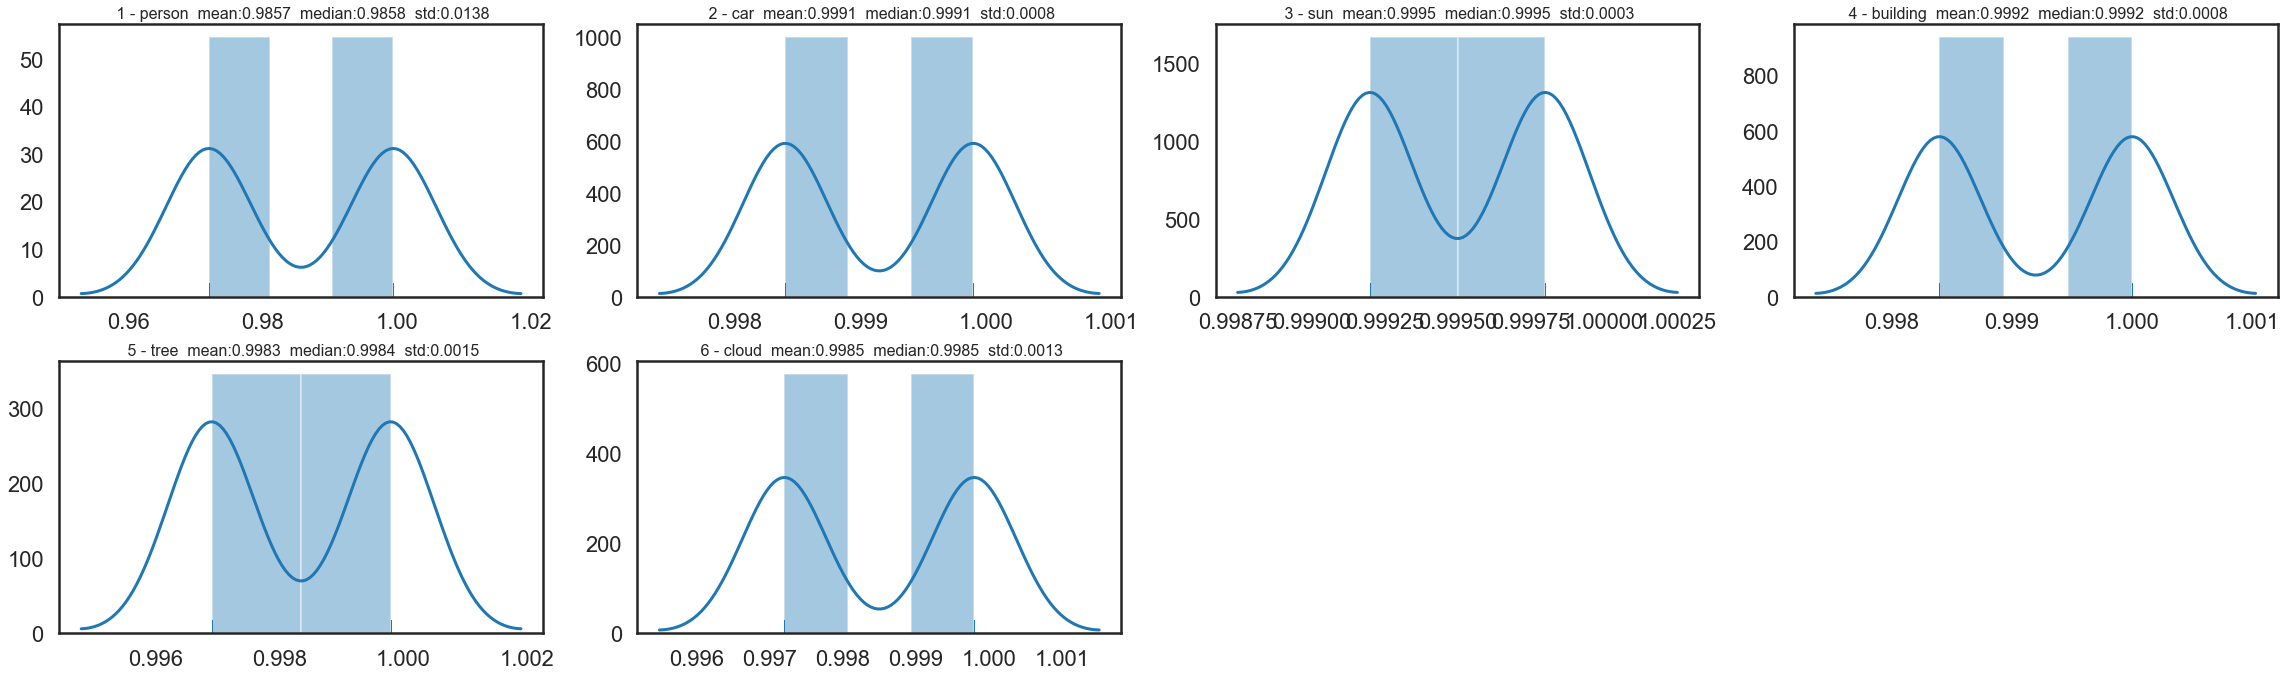

In [15]:
plot_score_distribution(cls_info, 'scores')

### `mrcnn_score_norm`

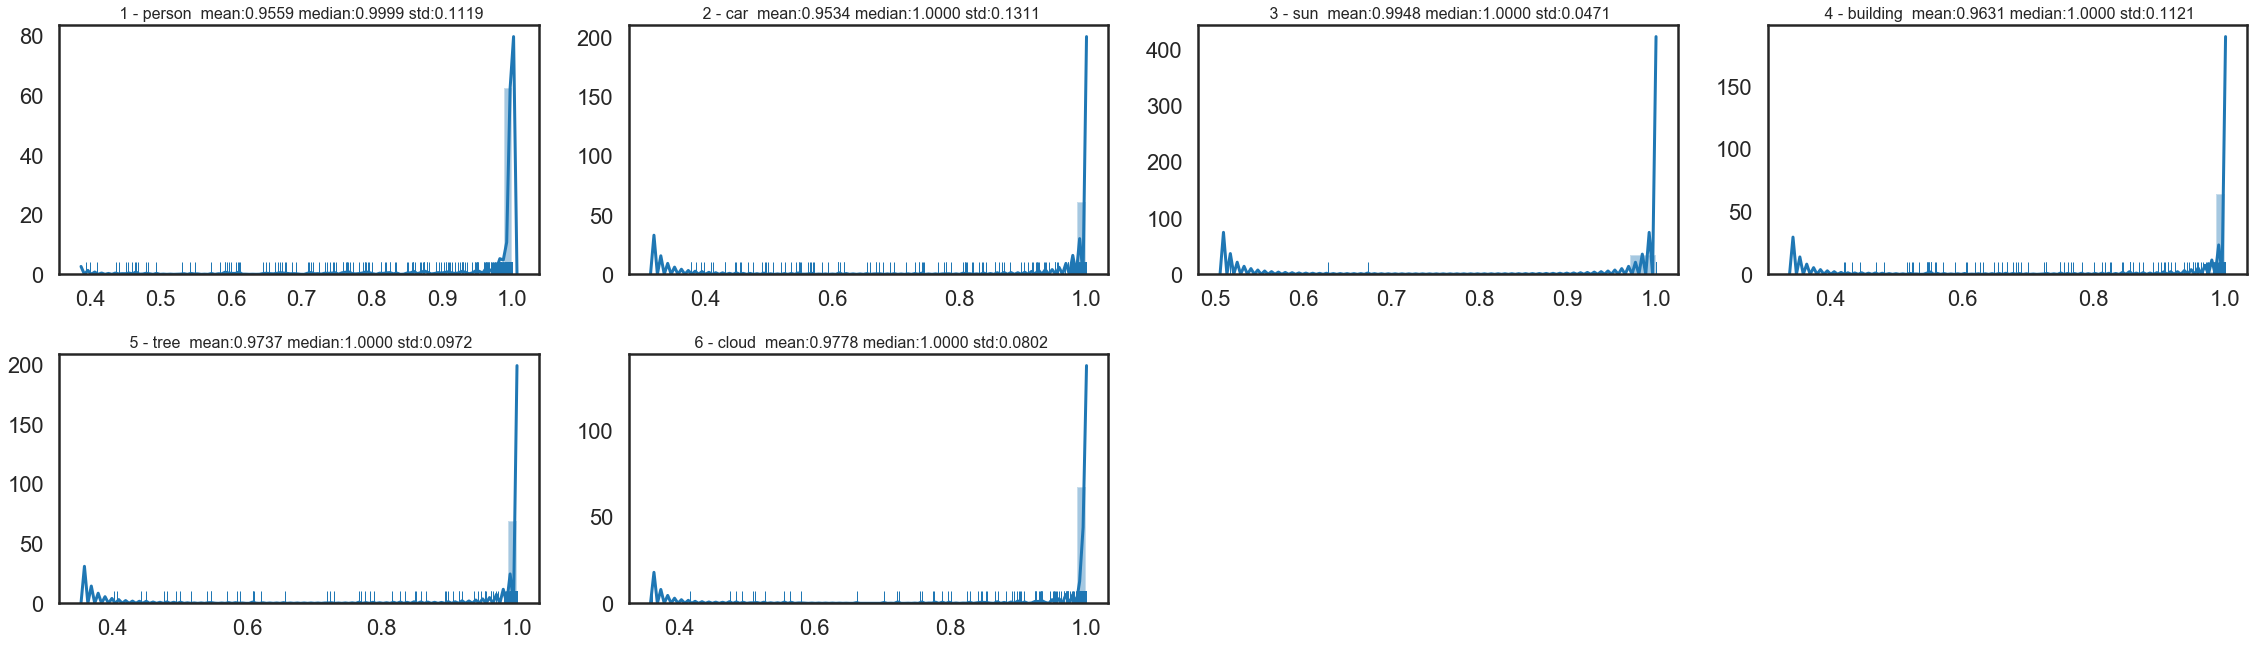

In [65]:
plot_score_distribution(cls_info, 'mrcnn_score_norm')

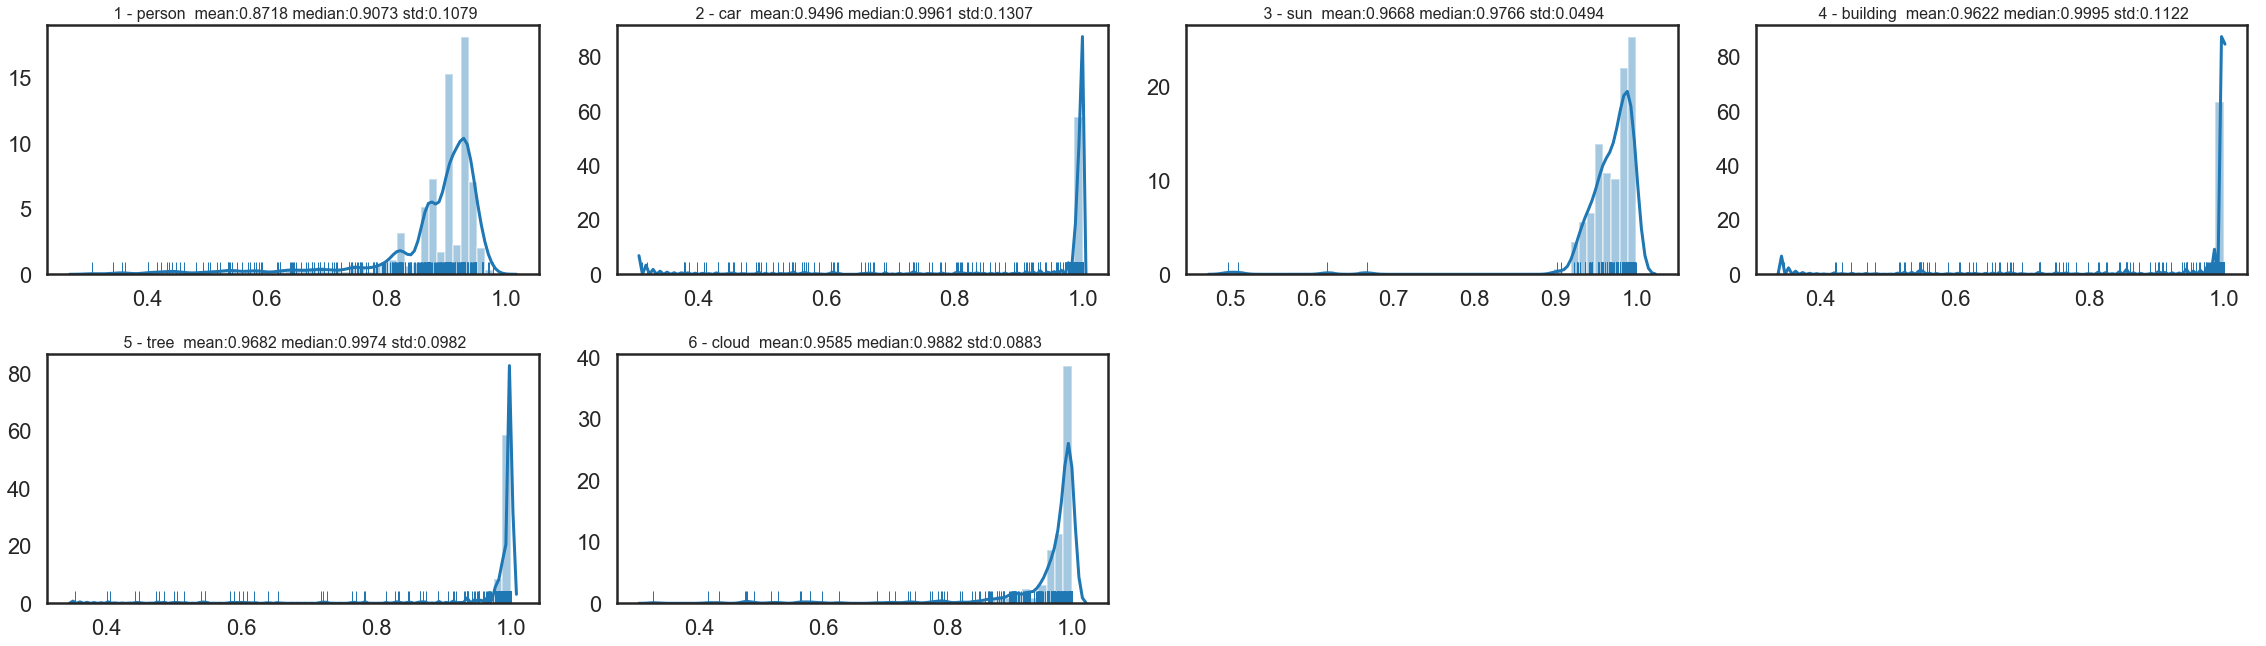

In [66]:
plot_score_distribution(cls_info, 'mrcnn_score_0')

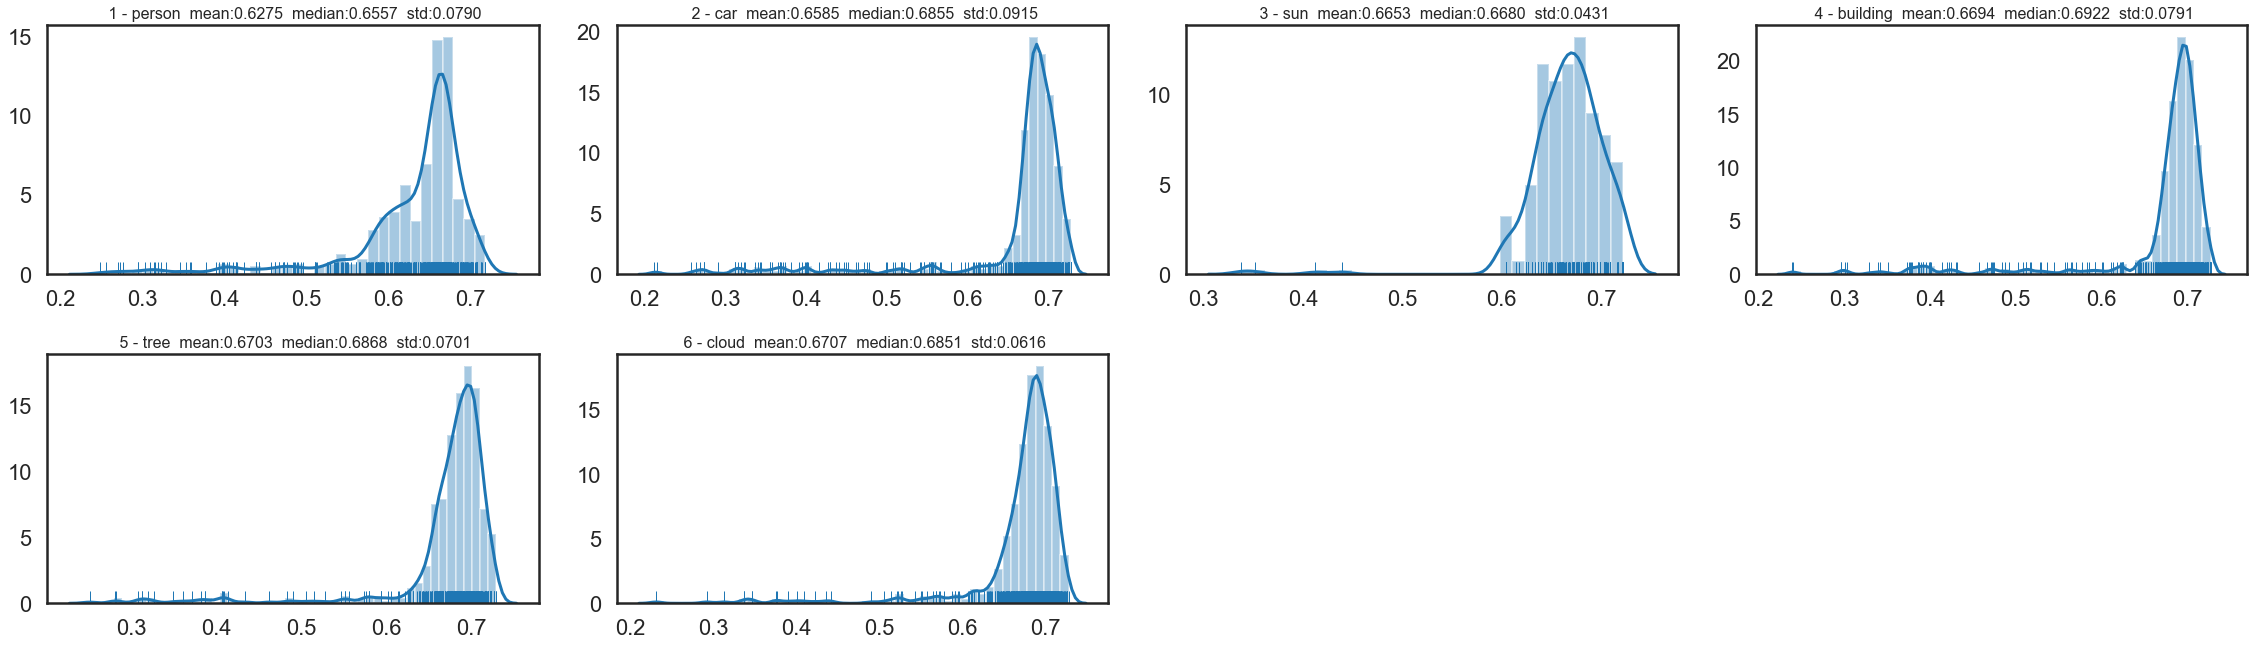

In [68]:
plot_score_distribution(cls_info, 'mrcnn_score_1')

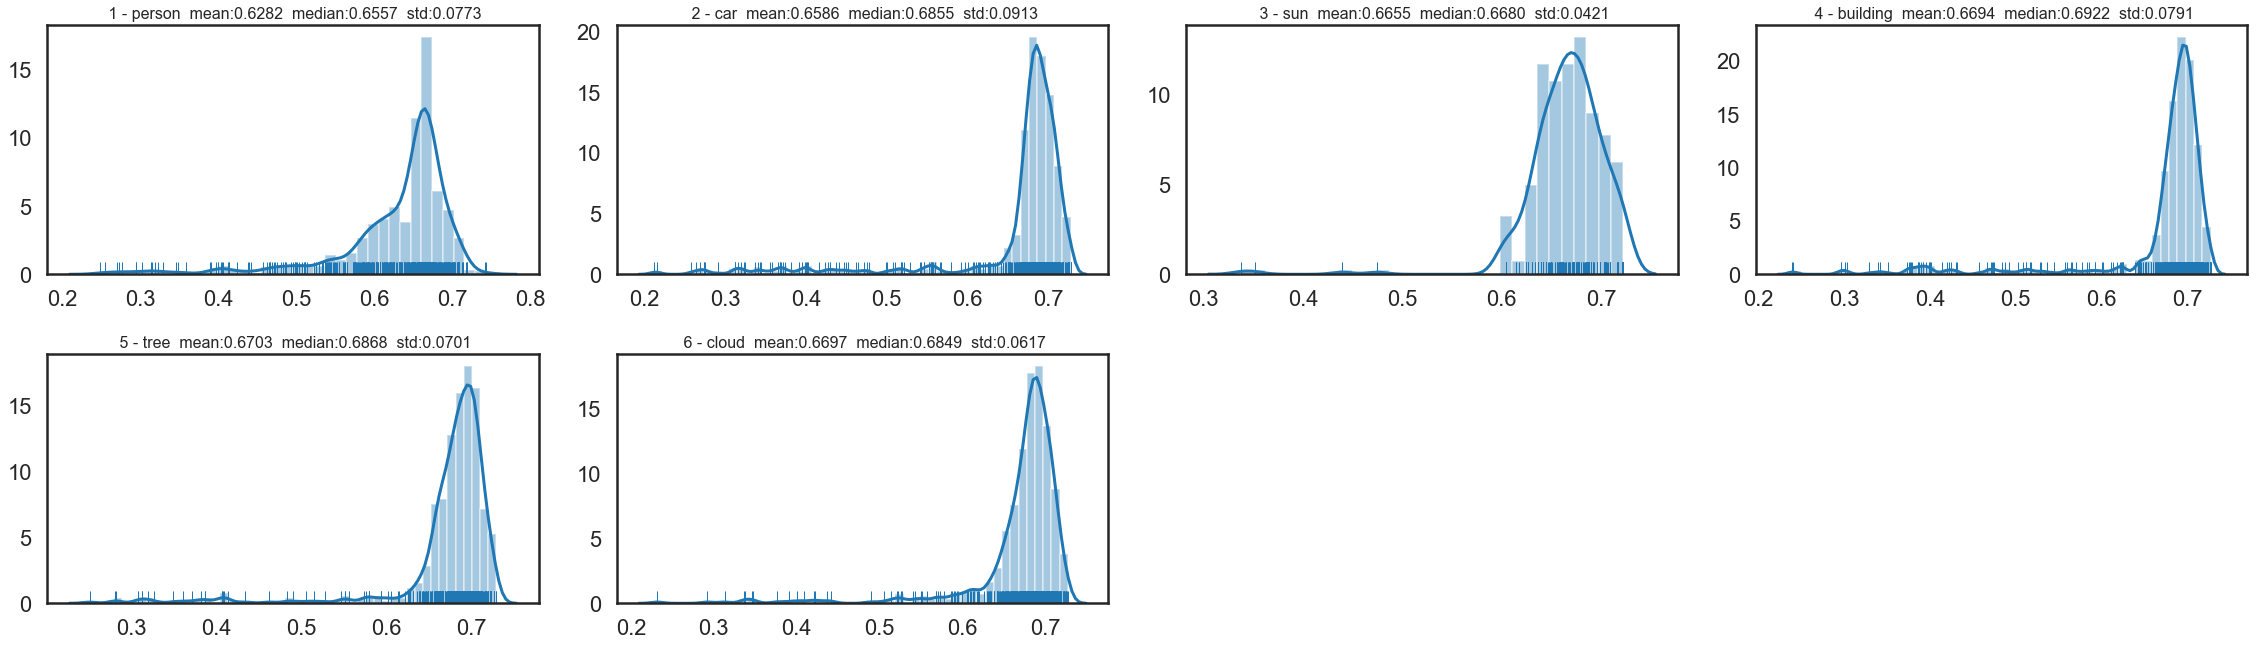

In [69]:
plot_score_distribution(cls_info, 'mrcnn_score_2')

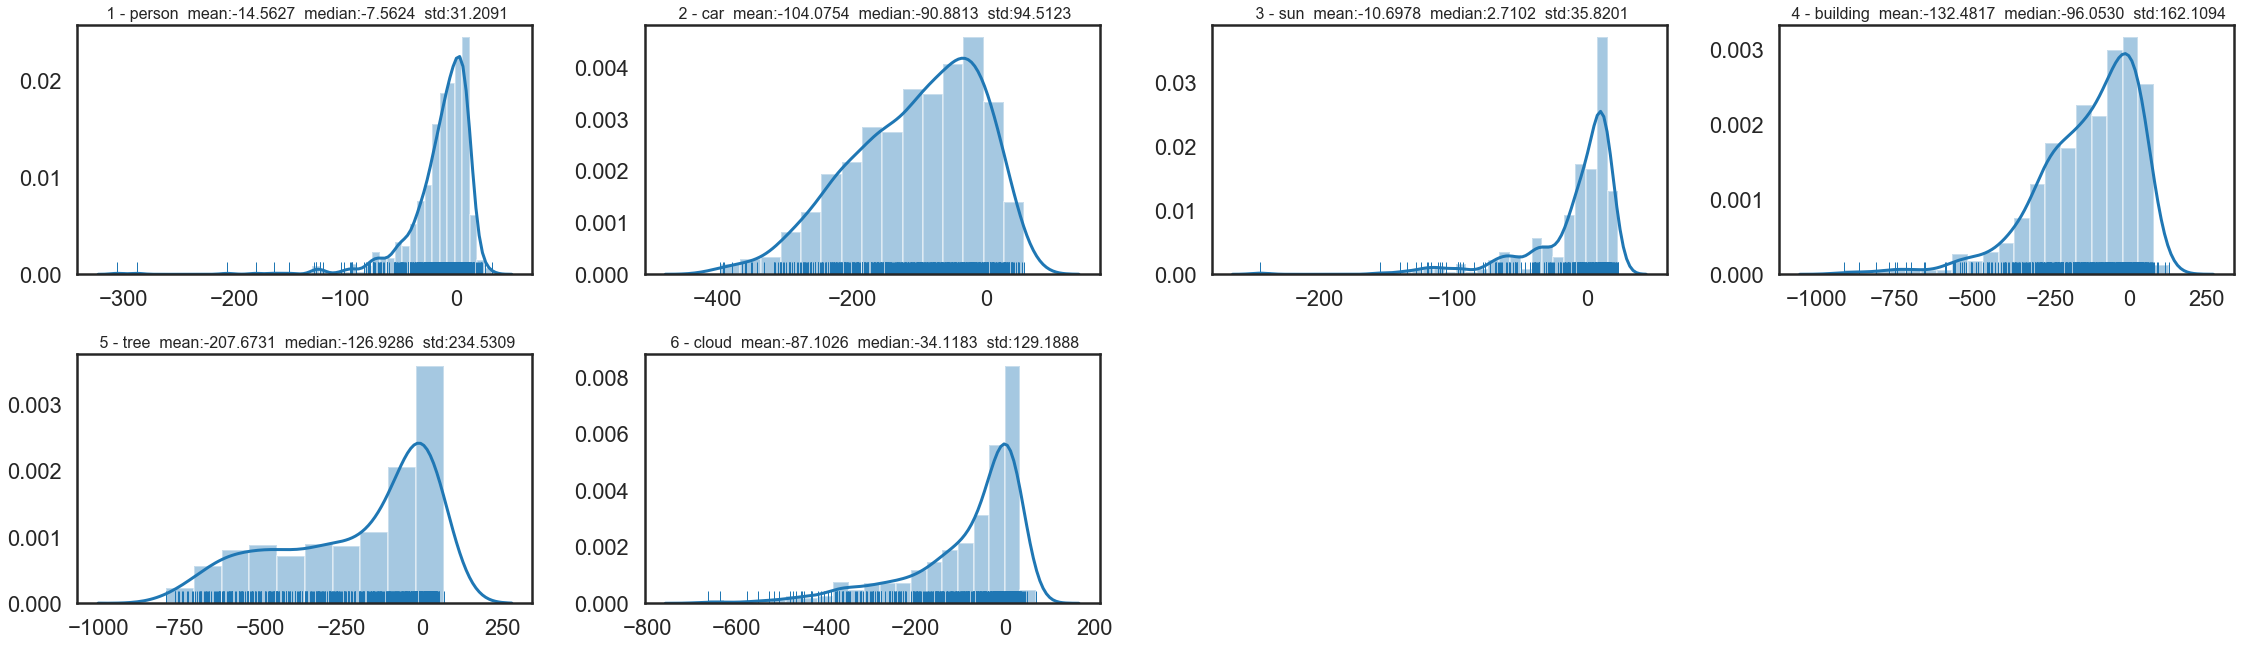

In [70]:
plot_score_distribution(cls_info, 'fcn_score_0')

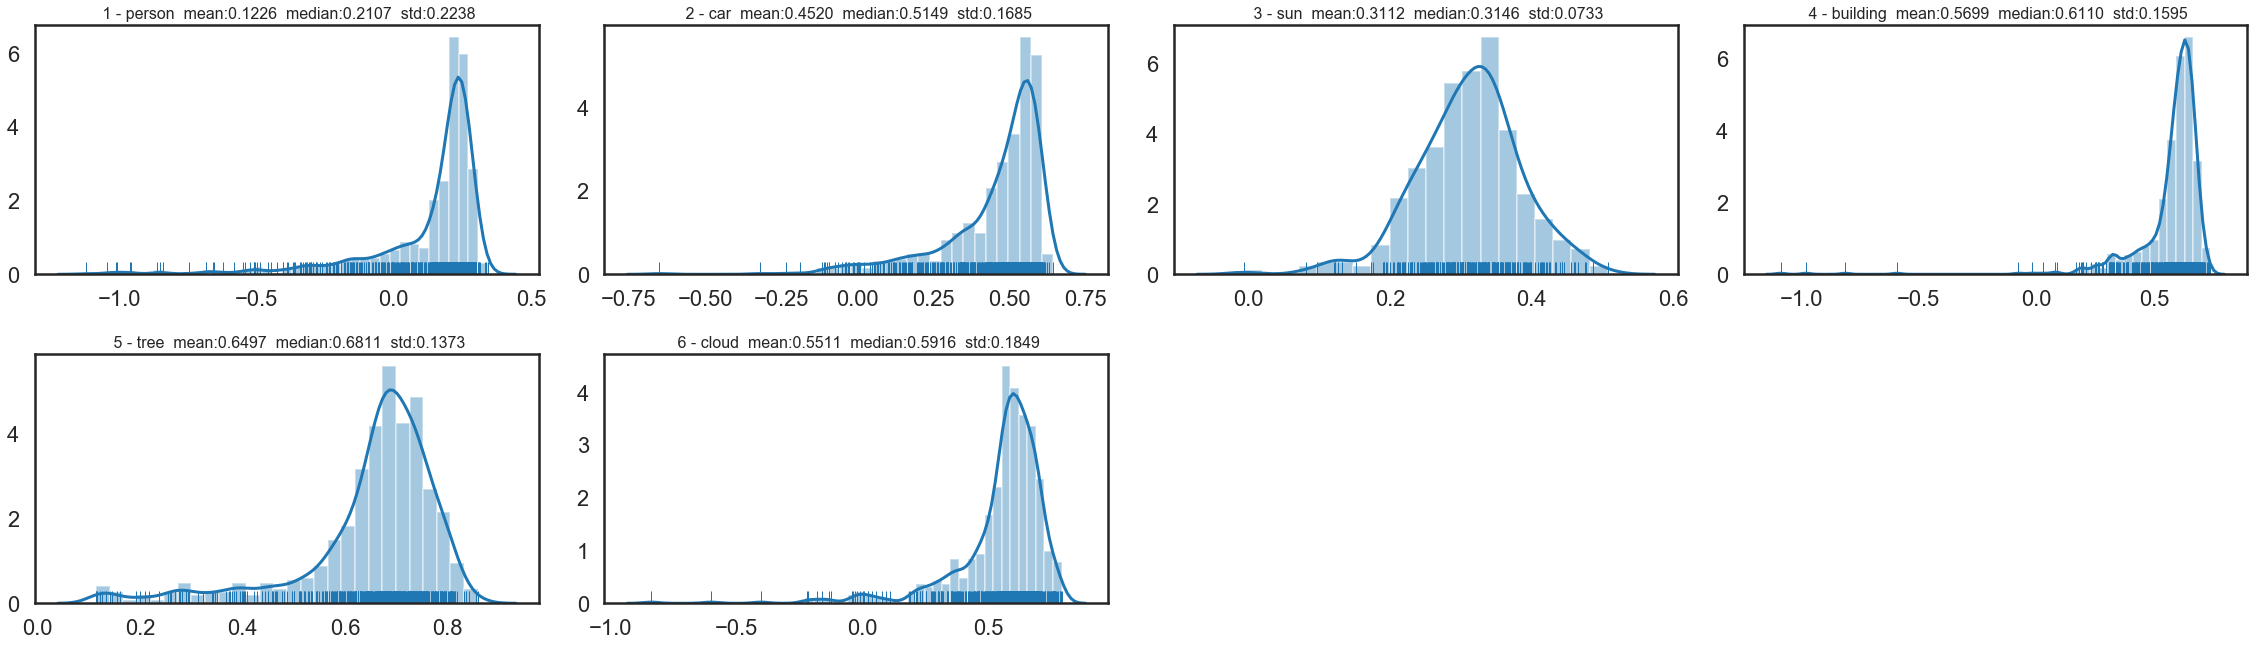

In [71]:
plot_score_distribution(cls_info, 'fcn_score_1')

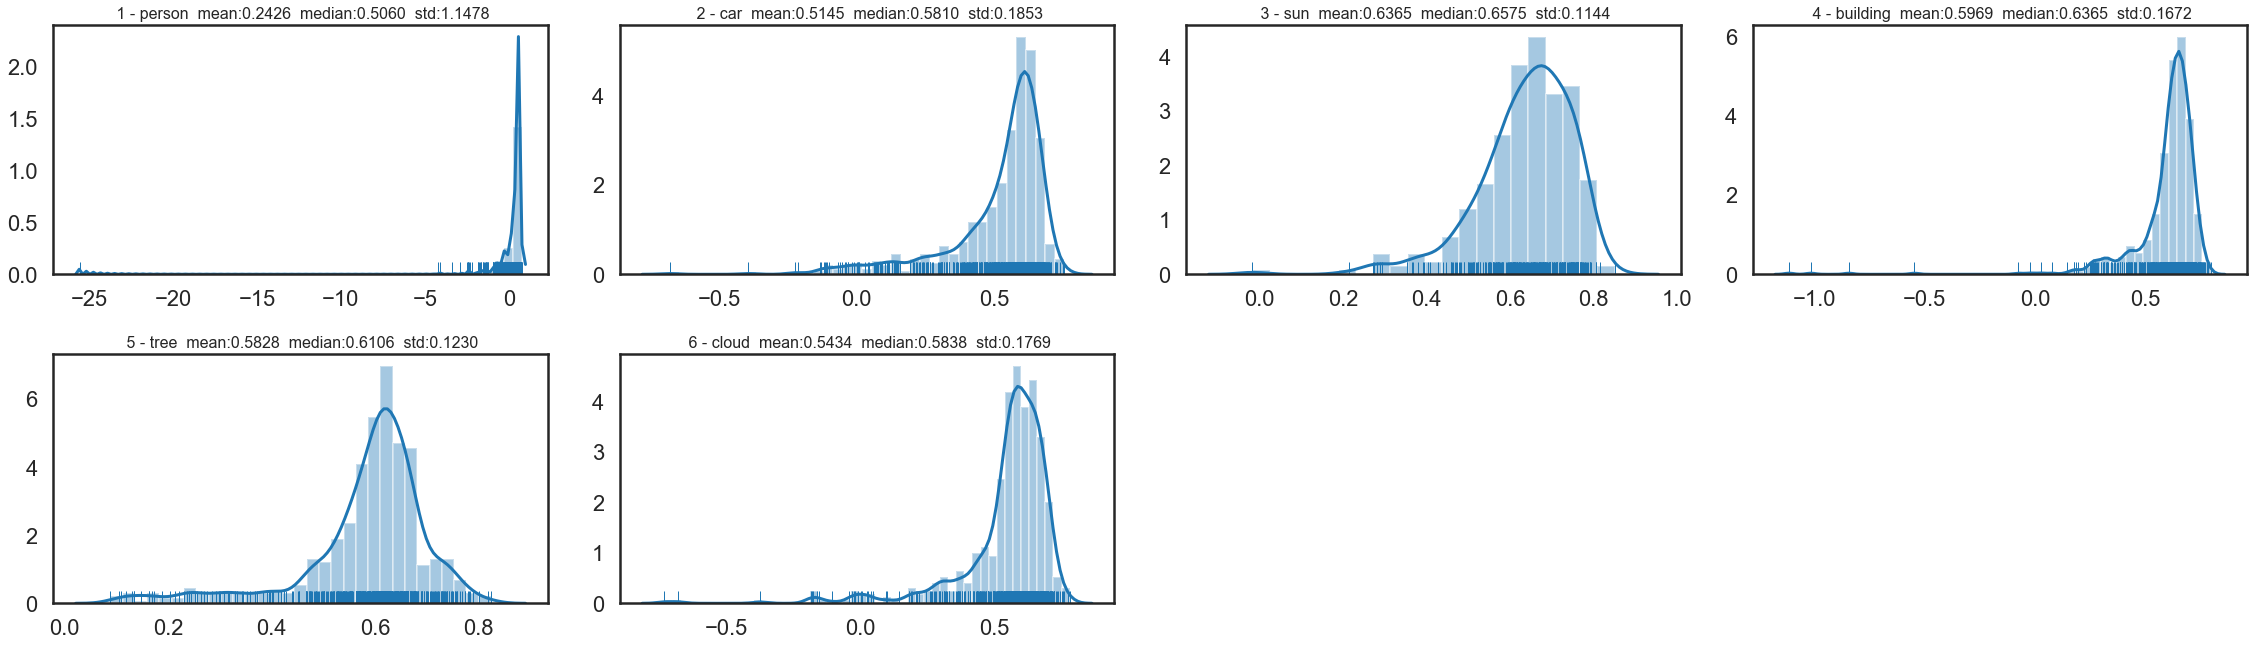

In [72]:
plot_score_distribution(cls_info, 'fcn_score_2')

#### display of gt_boxes_class, pr_boxes_class

In [ ]:
# gt_boxes_class, pr_boxes_class = filter_by_class(gt_boxes, pr_boxes, class_id= 5)
gt_boxes_class, pr_boxes_class = filter_by_class_2(gt_boxes, pr_boxes, class_id= 2)
print(type(gt_boxes_class), type(pr_boxes_class))
pr_keys = list(pr_boxes_class.keys())
gt_keys = list(gt_boxes_class.keys())
print(len(gt_boxes.keys()), len(pr_boxes.keys()))
print(len(gt_keys), gt_keys[:10])
print(len(pr_keys), pr_keys[:10])
sel_gt_keys = gt_keys[:3]
sel_pr_keys = pr_keys[:3]
# pp.pprint(pr_boxes['newshapes_00002'])
for key in gt_keys[:3]:
    print('-----------------------')
    print('Key: ', key)
    print('-----------------------')
    pp.pprint(pr_boxes_class[key])
    print()
    pp.pprint(gt_boxes_class[key])

In [ ]:

# class_ids     = [10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 69, 70, 71, 72, 73]
# Runs it for one IoU threshold


##  Create `gt_boxes`, `pr_boxes` separated by class

In [73]:
# class_ids     = [10, 11, 12, 13, 14, 
#                  15, 30, 31, 32, 33, 
#                  34, 35, 36, 37, 38, 
#                  39, 40, 41, 42, 43,
#                  44, 46, 69, 70, 71, 
#                  72, 73]
class_ids = [1,2,3,4,5,6]
## build gt_boxes_class, pr_boxes_class which only containing info for each class 
gt_boxes_class = {}
pr_boxes_class = {}

for cls in class_ids :
    print('class id :', cls)
    a, b = filter_by_class(gt_boxes, pr_boxes, class_id= cls)
    gt_boxes_class[cls] = a
    pr_boxes_class[cls] = b
print(gt_boxes_class.keys())    
print(pr_boxes_class.keys())    
print(gt_boxes_class[1]['newshapes_00492'].keys())


class id : 1
class id : 2
class id : 3
class id : 4
class id : 5
class id : 6
dict_keys([1, 2, 3, 4, 5, 6])
dict_keys([1, 2, 3, 4, 5, 6])
dict_keys(['class_ids', 'boxes'])


### Display mAP for one class and one threshold

In [ ]:
cls = 1

iou_thr = 0.5
start_time = time.time()
data =  cmap.get_avg_precision_at_iou(gt_boxes_class[cls], pr_boxes_class[cls], iou_thr=iou_thr, score_key = 'scores')
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))
# pp.pprint(data)

idx = 0
ax = None
avg_precs = []
iou_thrs = []
avg_precs.append(data['avg_prec'])
iou_thrs.append(iou_thr)
precisions = data['precisions']
recalls    = data['recalls']
print(iou_thrs)
print(avg_precs)
print(' precisions: ', precisions.shape)
print(' recalls   : ', recalls.shape)
ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

## Build Average Precision Data Structure for all class ids we are interested in 
Using loaded gt_boxes and pr_boxes.
    ALL_DATA is a dictionary keyed by class_id to dictionaries, one for each possible score. Each SCORE dictionary is itrself a dictionary with keys for iOUs 
    between 0.5 and 0.95. Each dictionary entry has the following keys:
    {'iou', 'model_thrs', 'recalls', 'precisions', 'avg_prec'}
    iou :         indicates the iOU threshold of the dictionary entry
    model_thrs:   score thresholds
    recalls   :   recall at threshold
    precision :   precision at threshold

In [75]:
# del all_data
class_ids = [1,2,3,4,5,6]
scores    = ['scores', 'mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']

all_data = build_mAP_data_structure(gt_boxes_class, pr_boxes_class, class_ids, scores)

Build mAP information for classes:  [1, 2, 3, 4, 5, 6]  and scores  ['scores', 'mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
class id:  1   idx  0  iou_thr 0.5   score_key:  scores
class id:  1   idx  1  iou_thr 0.55   score_key:  scores
class id:  1   idx  2  iou_thr 0.6   score_key:  scores
class id:  1   idx  3  iou_thr 0.65   score_key:  scores
class id:  1   idx  4  iou_thr 0.7   score_key:  scores
class id:  1   idx  5  iou_thr 0.75   score_key:  scores
class id:  1   idx  6  iou_thr 0.8   score_key:  scores
class id:  1   idx  7  iou_thr 0.85   score_key:  scores
class id:  1   idx  8  iou_thr 0.9   score_key:  scores
class id:  1   idx  0  iou_thr 0.5   score_key:  mrcnn_score_orig
class id:  1   idx  1  iou_thr 0.55   score_key:  mrcnn_score_orig
class id:  1   idx  2  iou_thr 0.6   score_key:  mrcnn_score_orig
class id:  1   idx  3  iou_thr 0.65   score_key:  mrcnn_score_orig
class id:  

class id:  2   idx  1  iou_thr 0.55   score_key:  mrcnn_score_2
class id:  2   idx  2  iou_thr 0.6   score_key:  mrcnn_score_2
class id:  2   idx  3  iou_thr 0.65   score_key:  mrcnn_score_2
class id:  2   idx  4  iou_thr 0.7   score_key:  mrcnn_score_2
class id:  2   idx  5  iou_thr 0.75   score_key:  mrcnn_score_2
class id:  2   idx  6  iou_thr 0.8   score_key:  mrcnn_score_2
class id:  2   idx  7  iou_thr 0.85   score_key:  mrcnn_score_2
class id:  2   idx  8  iou_thr 0.9   score_key:  mrcnn_score_2
class id:  2   idx  0  iou_thr 0.5   score_key:  fcn_score_0
class id:  2   idx  1  iou_thr 0.55   score_key:  fcn_score_0
class id:  2   idx  2  iou_thr 0.6   score_key:  fcn_score_0
class id:  2   idx  3  iou_thr 0.65   score_key:  fcn_score_0
class id:  2   idx  4  iou_thr 0.7   score_key:  fcn_score_0
class id:  2   idx  5  iou_thr 0.75   score_key:  fcn_score_0
class id:  2   idx  6  iou_thr 0.8   score_key:  fcn_score_0
class id:  2   idx  7  iou_thr 0.85   score_key:  fcn_score_0


class id:  4   idx  8  iou_thr 0.9   score_key:  mrcnn_score_orig
class id:  4   idx  0  iou_thr 0.5   score_key:  mrcnn_score_norm
class id:  4   idx  1  iou_thr 0.55   score_key:  mrcnn_score_norm
class id:  4   idx  2  iou_thr 0.6   score_key:  mrcnn_score_norm
class id:  4   idx  3  iou_thr 0.65   score_key:  mrcnn_score_norm
class id:  4   idx  4  iou_thr 0.7   score_key:  mrcnn_score_norm
class id:  4   idx  5  iou_thr 0.75   score_key:  mrcnn_score_norm
class id:  4   idx  6  iou_thr 0.8   score_key:  mrcnn_score_norm
class id:  4   idx  7  iou_thr 0.85   score_key:  mrcnn_score_norm
class id:  4   idx  8  iou_thr 0.9   score_key:  mrcnn_score_norm
class id:  4   idx  0  iou_thr 0.5   score_key:  mrcnn_score_0
class id:  4   idx  1  iou_thr 0.55   score_key:  mrcnn_score_0
class id:  4   idx  2  iou_thr 0.6   score_key:  mrcnn_score_0
class id:  4   idx  3  iou_thr 0.65   score_key:  mrcnn_score_0
class id:  4   idx  4  iou_thr 0.7   score_key:  mrcnn_score_0
class id:  4   idx 

In [76]:
print(all_data.keys())
print(all_data[1].keys())
print(all_data[1]['mrcnn_score_2'].keys())
print(all_data[1]['mrcnn_score_2'][0.5].keys())

dict_keys([1, 2, 3, 4, 5, 6])
dict_keys(['fcn_score_2', 'mrcnn_score_2', 'fcn_score_0', 'mrcnn_score_orig', 'scores', 'mrcnn_score_1', 'fcn_score_1', 'mrcnn_score_norm', 'mrcnn_score_0'])
dict_keys([0.5, 0.55, 0.85, 0.6, 0.8, 0.7, 0.9, 0.65, 0.75])
dict_keys(['recalls', 'model_thrs', 'iou', 'avg_prec', 'precisions'])


In [ ]:
# for lst in all_data[1]:
#     print(lst)
#     print(all_data[1][lst])
# #     ['iou'], lst['avg_prec'])
#     print(len(all_data[1][lst]['model_thrs']), len(all_data[1][lst]['precisions']), len(all_data[1][lst]['recalls']))

## Plot mAP info for all classes at different thresholds (one type of score, e.g. 'scores')

### Plot mAP for `mrcnn_score_orig`


                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_orig                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.8037     0.7942     0.6825     0.5367     0.3677     0.1793     0.0995     0.0322     0.0059      %38.91 
  2 - car                         0.9082     0.9016     0.8977     0.8926     0.7906     0.7344     0.4946     0.2506     0.0744      %66.05 
  3 - sun                         0.9091     0.9091     0.9075     0.9062     0.8902     0.8670     0.6463     0.4497     0.1539      %73.77 
  4 - buil

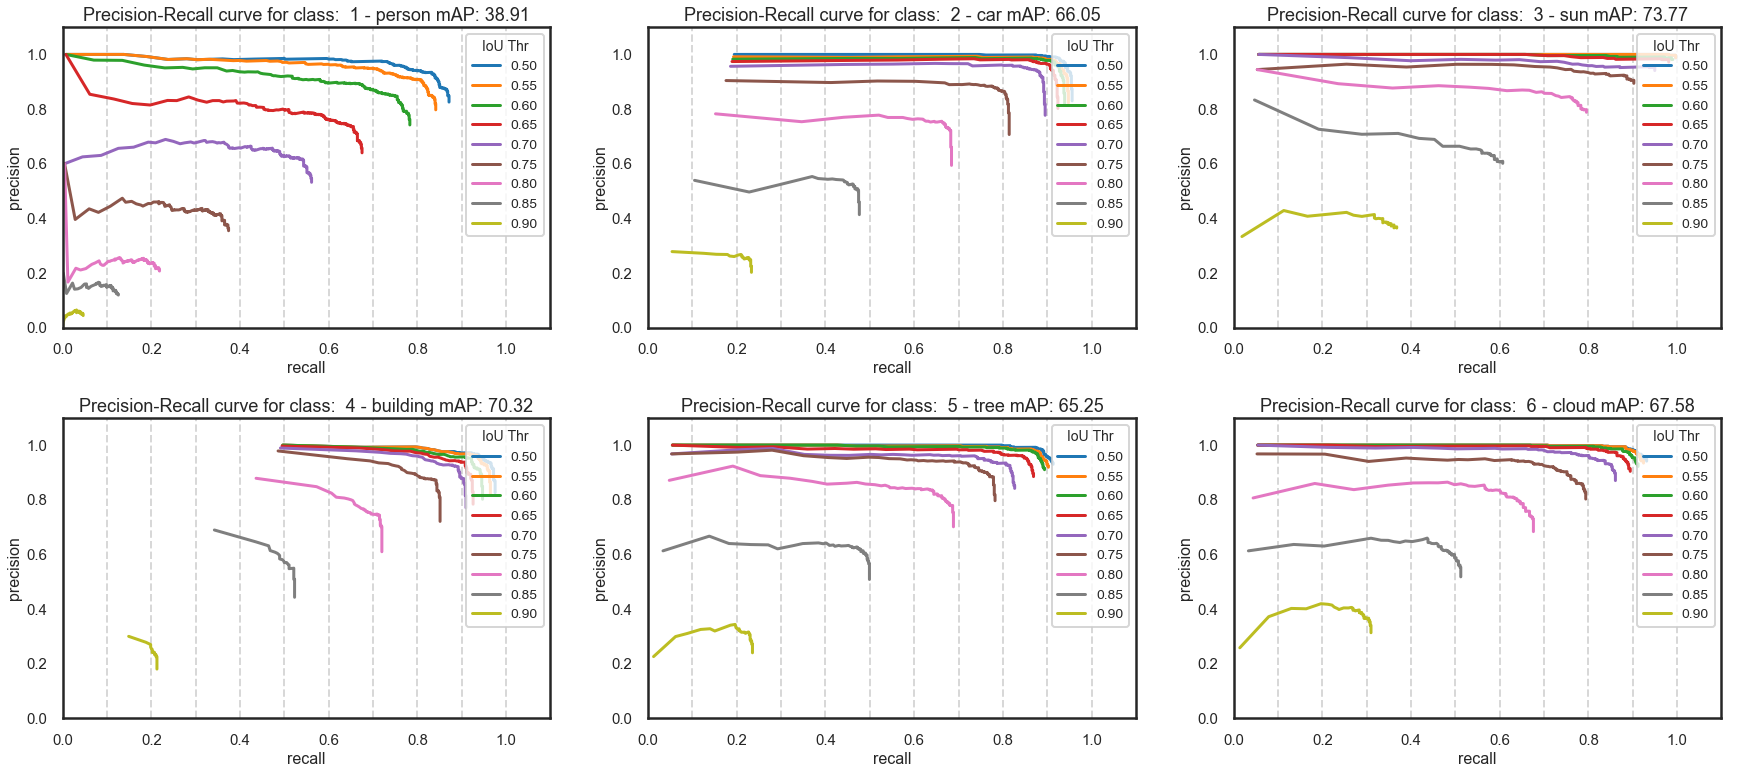

In [162]:
# plot_mAP_by_score(all_data, 'scores' )
plot_mAP_by_IOU(all_data, 'mrcnn_score_orig' )

### Plot mAP for `mrcnn_score_norm`


                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_norm                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.7777     0.7569     0.6442     0.4946     0.3545     0.1565     0.0654     0.0264     0.0050      %36.46 
  2 - car                         0.8921     0.8852     0.8817     0.8759     0.7737     0.7111     0.4763     0.2429     0.0719      %64.56 
  3 - sun                         0.9062     0.9062     0.8977     0.8919     0.8634     0.8205     0.5786     0.3862     0.1338      %70.94 
  4 - buil

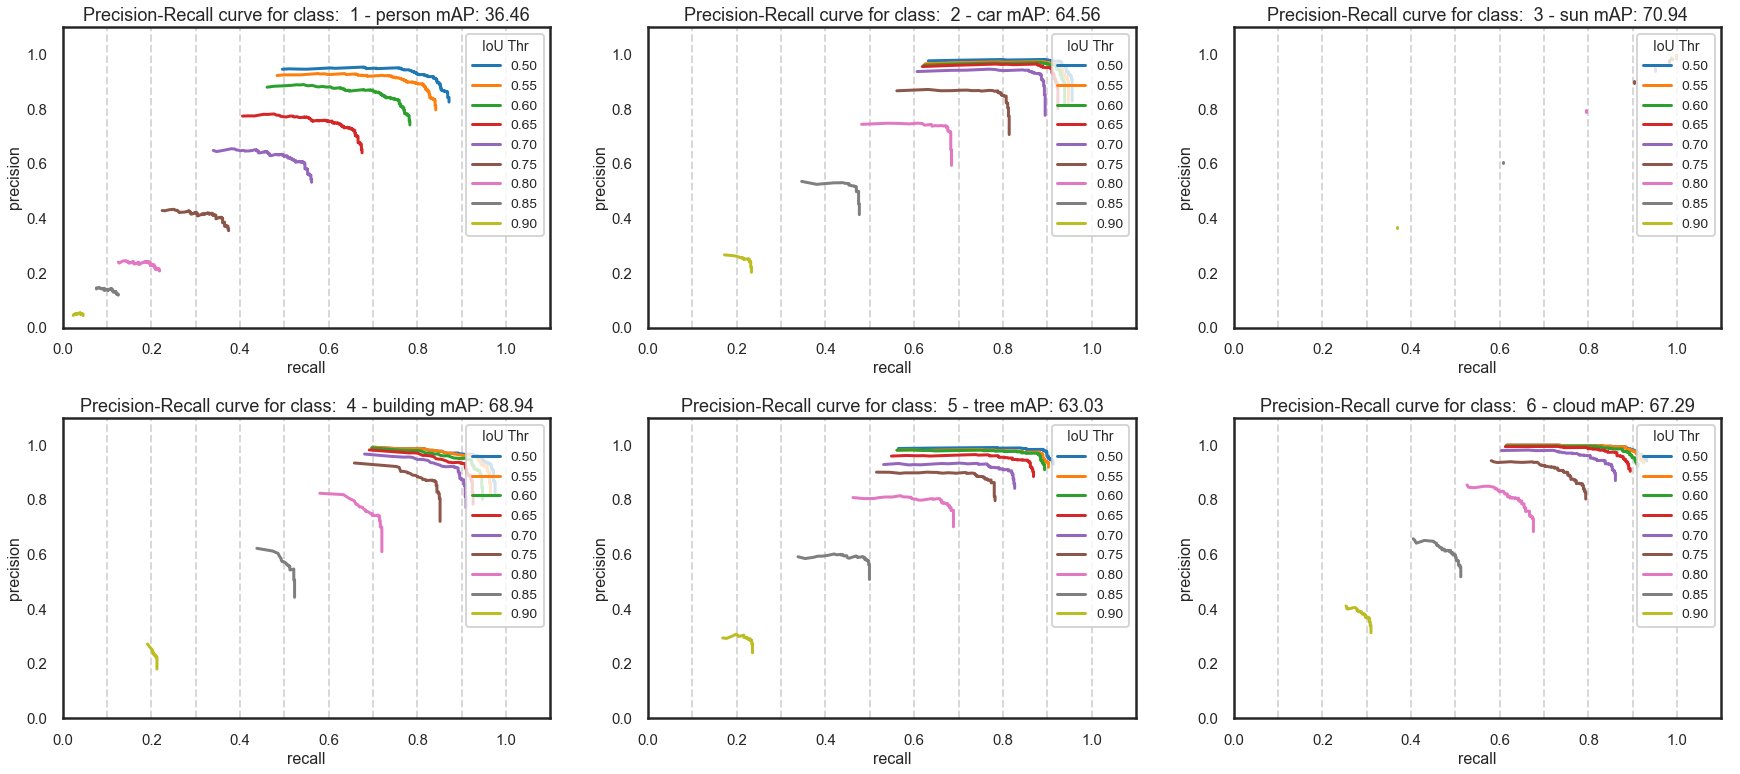

In [163]:
plot_mAP_by_IOU(all_data, 'mrcnn_score_norm')

### Plot mAP for `mrcnn_score_0`


                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_0                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.7767     0.7477     0.6345     0.5121     0.3642     0.1580     0.0731     0.0269     0.0059      %36.66 
  2 - car                         0.8972     0.8914     0.8851     0.8752     0.7737     0.7341     0.4995     0.2748     0.0854      %65.74 
  3 - sun                         0.9091     0.9091     0.9020     0.8942     0.8713     0.8538     0.6252     0.4216     0.1530      %72.66 
  4 - buil

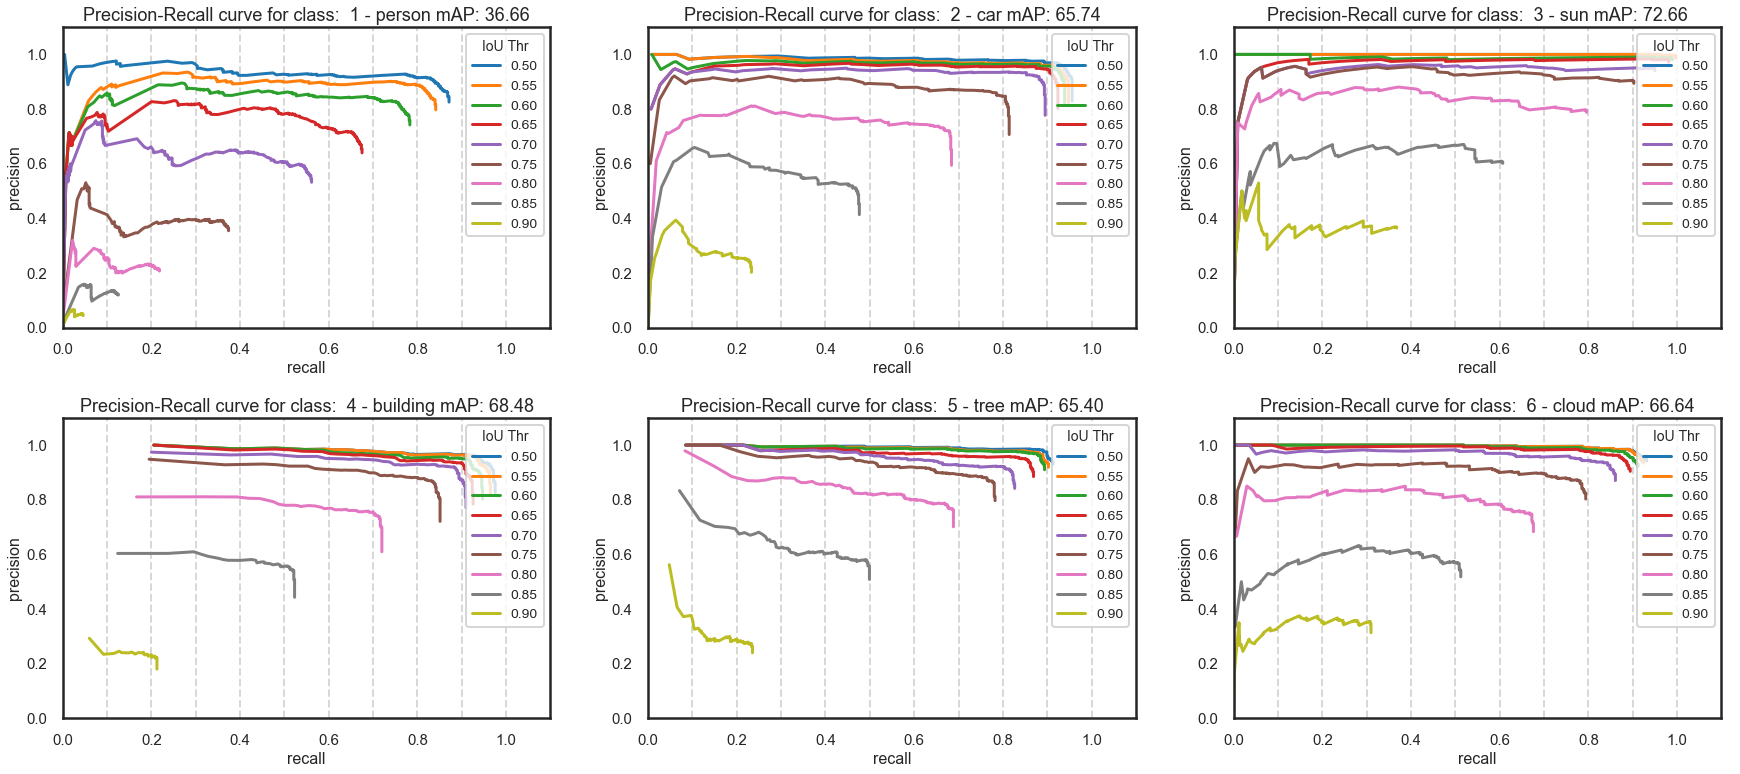

In [164]:
plot_mAP_by_IOU(all_data, 'mrcnn_score_0')

### Plot mAP for `mrcnn_score_1`


                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_1                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.7681     0.7508     0.6414     0.5258     0.3946     0.2080     0.0874     0.0242     0.0046      %37.83 
  2 - car                         0.8868     0.8802     0.8774     0.8688     0.7643     0.7040     0.4714     0.2573     0.0846      %64.39 
  3 - sun                         0.9079     0.9079     0.9018     0.8996     0.8708     0.8420     0.6106     0.4377     0.1617      %72.67 
  4 - buil

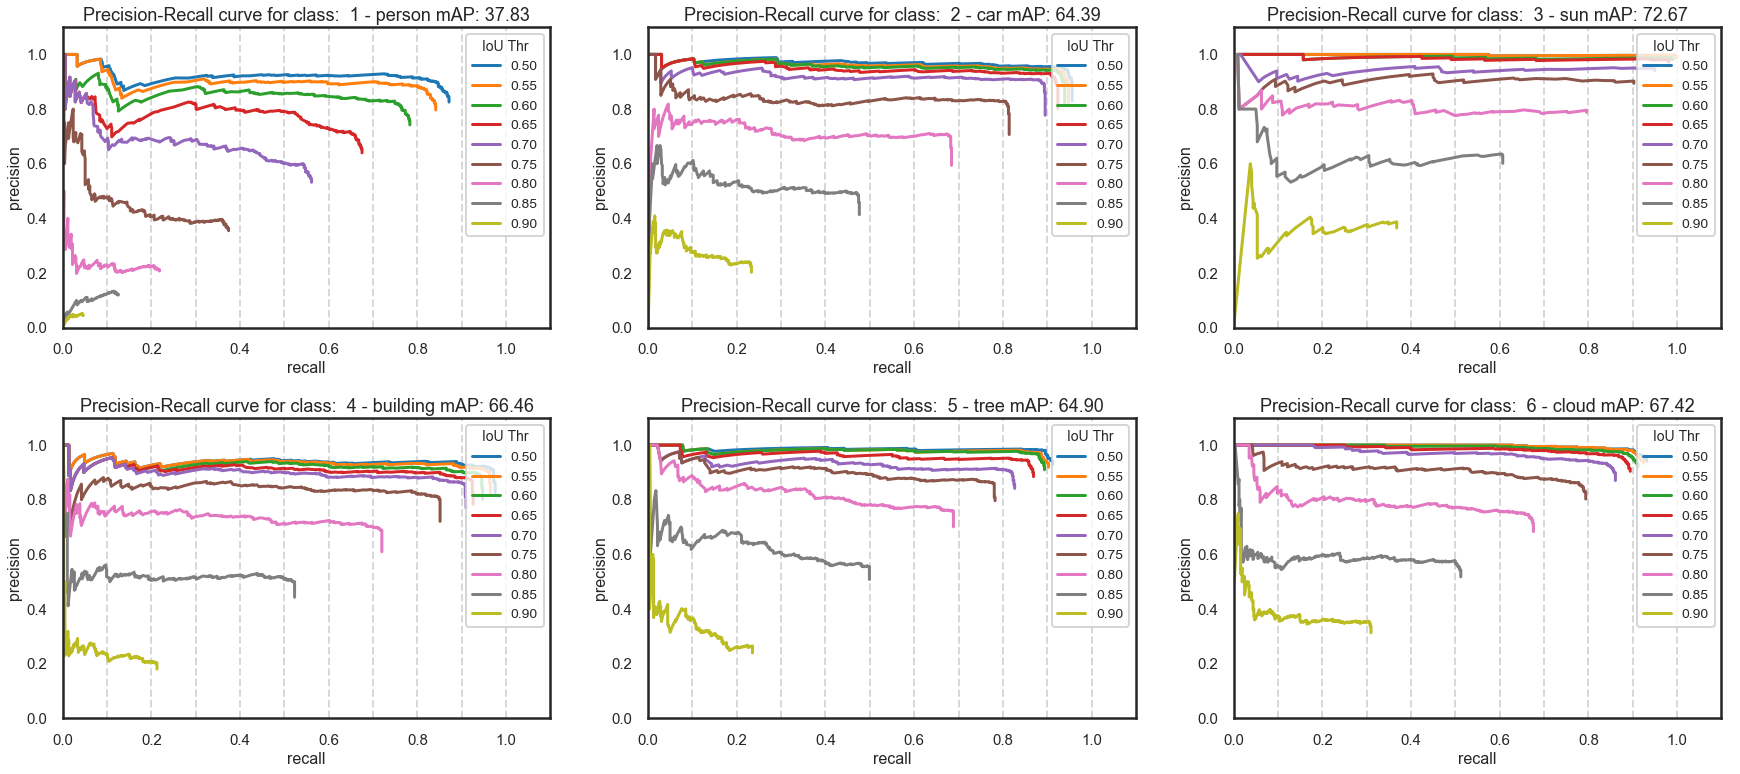

In [165]:
plot_mAP_by_IOU(all_data, 'mrcnn_score_1')

### Plot mAP for `mrcnn_score_2`


                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_2                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.7635     0.7462     0.6418     0.5269     0.3964     0.2068     0.1330     0.1030     0.0047      %39.14 
  2 - car                         0.8868     0.8802     0.8775     0.8688     0.7646     0.7042     0.4689     0.2566     0.0844      %64.36 
  3 - sun                         0.9079     0.9079     0.9018     0.8996     0.8708     0.8417     0.6104     0.4377     0.1617      %72.66 
  4 - buil

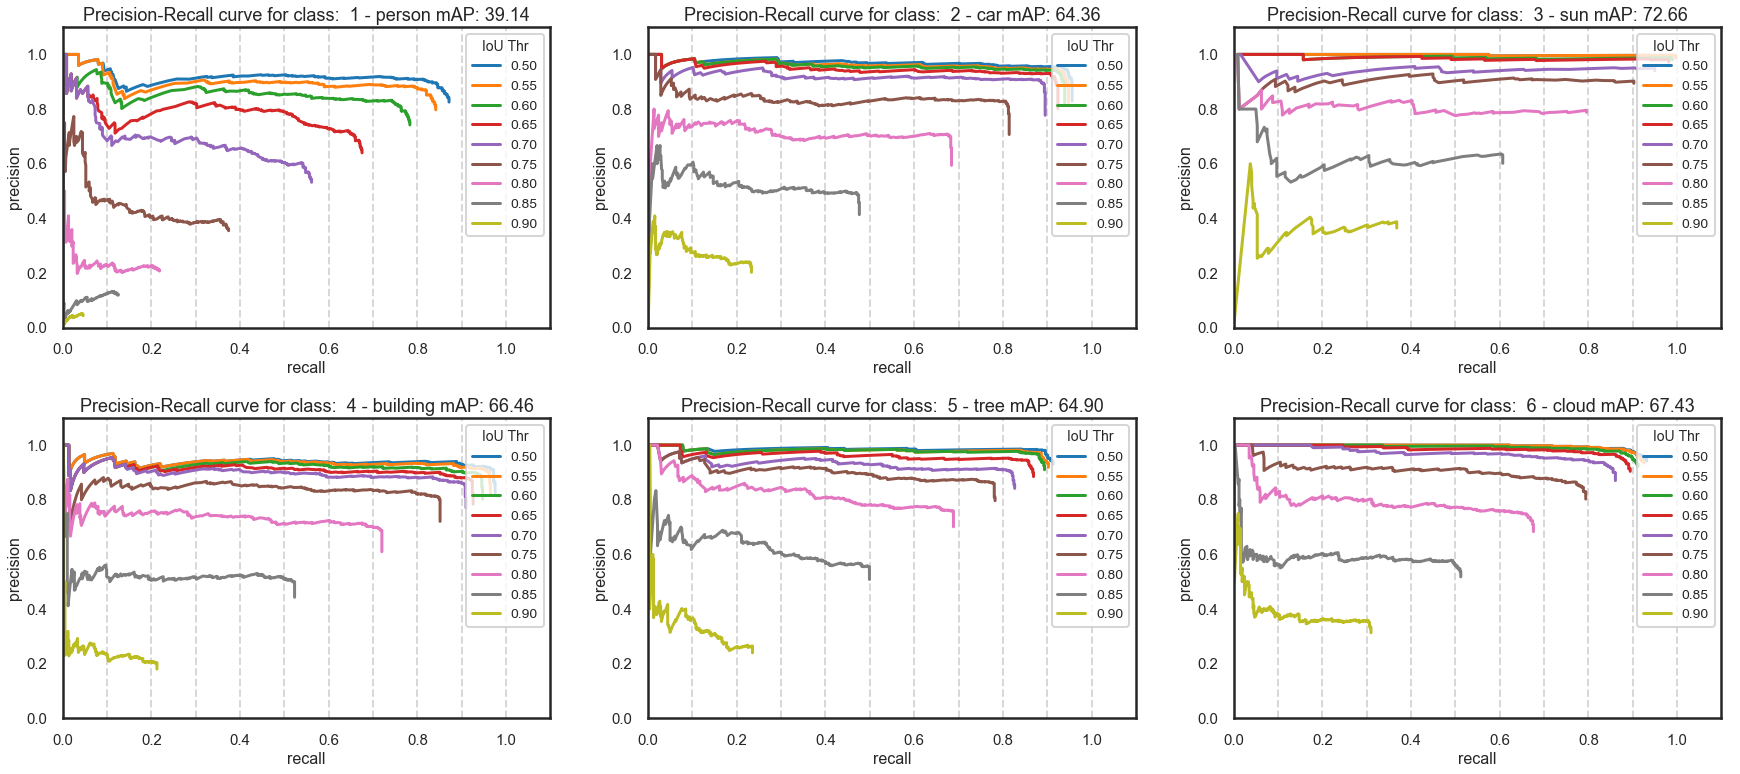

In [166]:
plot_mAP_by_IOU(all_data, 'mrcnn_score_2')

## Plot mAP info for different scores (at a given IoU threshold)

###  Calculate information for one class at one  threshold with different scores, e.g. 'scores')

class:  1  -  person
class:  2  -  car
class:  3  -  sun
class:  4  -  building
class:  5  -  tree
class:  6  -  cloud

                                                               AP @ IoU 0.50 Thresholds for Computed Scores                                                               

--------------------------------------------------------------------------------  scores  --------------------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig  mrcnn_score_norm     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_0       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.8037            0.7777            0.7767            0.7681            0.7635            0.7170            0.7682            0.7656 
 2 - car                     

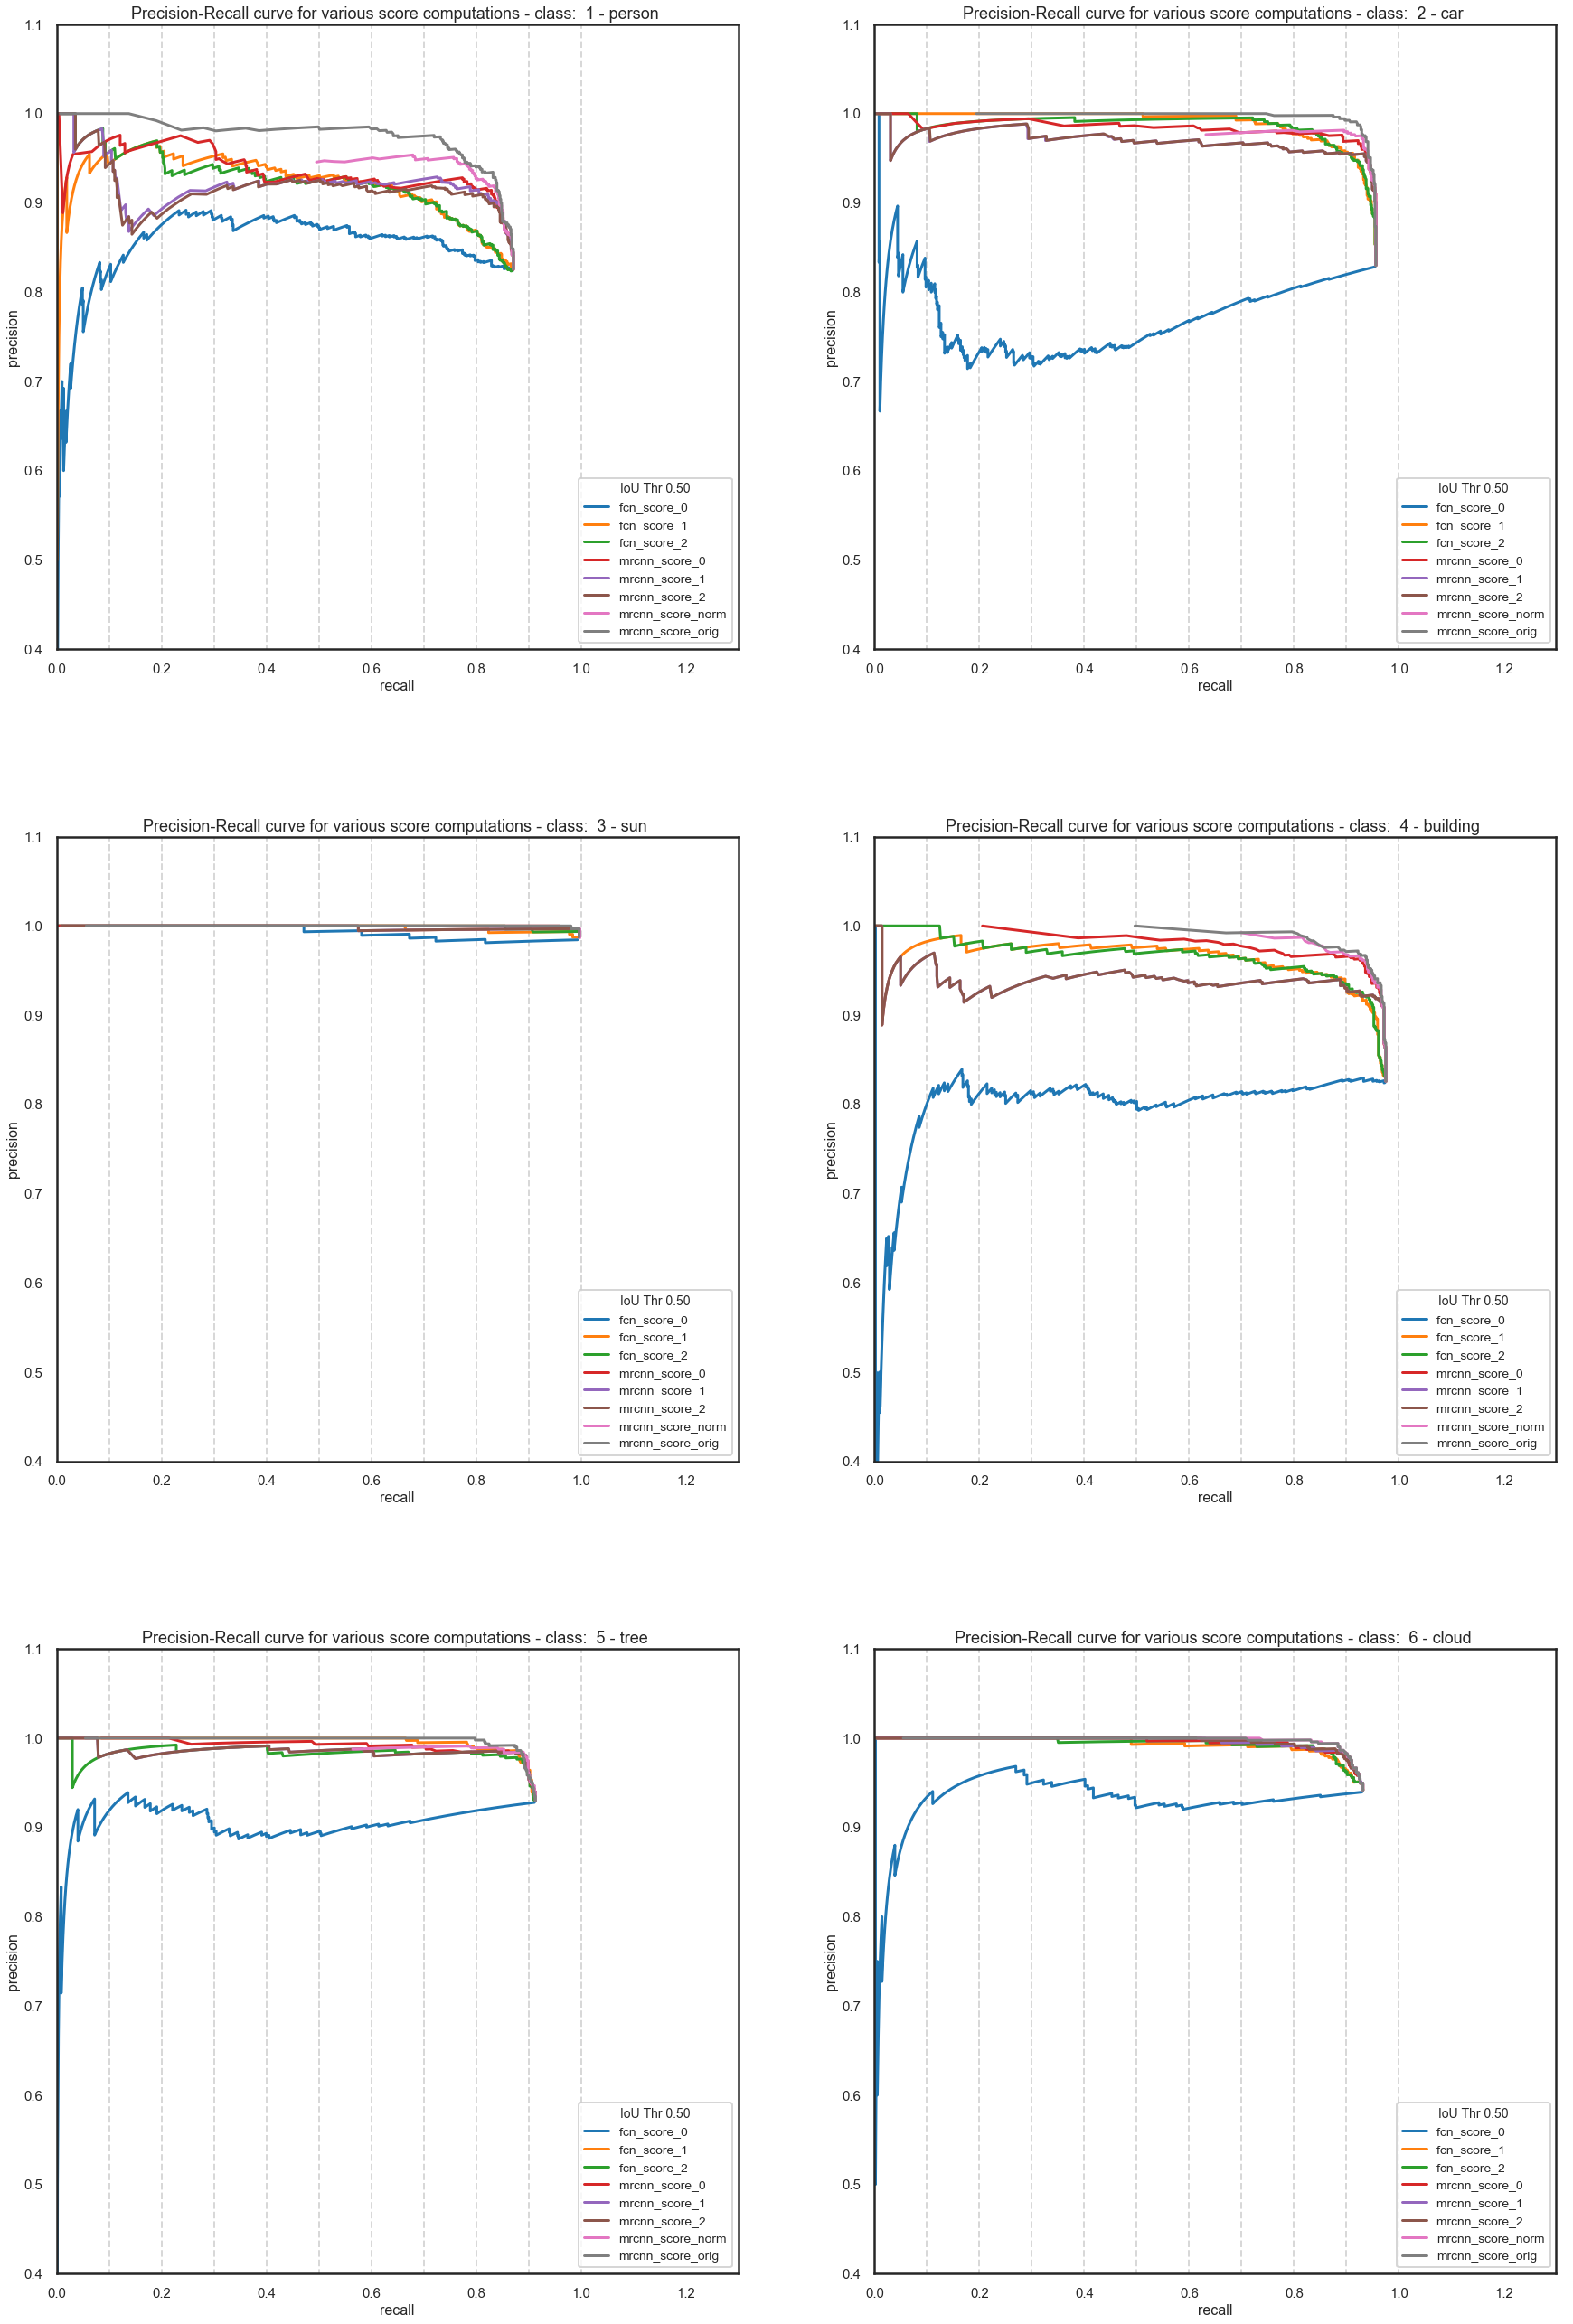

In [373]:
disp_classes = [1,2,3]  
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
plot_mAP_by_scores(all_data, scores = disp_scores, classes = disp_classes, iou = 0.5)

In [168]:
# cls = 1
# for i in pr_boxes_class[cls]:
#     print(i)
#     print(pr_boxes_class[cls][i]['scores'])
#     print(pr_boxes_class[cls][i]['mrcnn_score_orig'])
#     print(pr_boxes_class[cls][i]['mrcnn_score_norm'])
#     print('---------')

In [361]:
pp.pprint(all_data[1].keys())

dict_keys(['fcn_score_2', 'mrcnn_score_2', 'fcn_score_0', 'mrcnn_score_orig', 'scores', 'mrcnn_score_1', 'fcn_score_1', 'mrcnn_score_norm', 'mrcnn_score_0'])


In [372]:
pp.pprint(all_data[1]['mrcnn_score_norm'])

{ 0.5: { 'avg_prec': 0.7777212770838705,
         'iou': 0.5,
         'model_thrs': [ 0.3934,
                         0.4001,
                         0.4098,
                         0.4369,
                         0.4413,
                         0.4512,
                         0.453,
                         0.4589,
                         0.4639,
                         0.465,
                         0.4674,
                         0.4793,
                         0.4815,
                         0.4935,
                         0.5309,
                         0.5422,
                         0.5495,
                         0.5711,
                         0.5848,
                         0.5909,
                         0.5917,
                         0.5942,
                         0.5971,
                         0.6002,
                         0.6076,
                         0.6094,
                         0.6109,
                         0.6131,
                

                          0.9992,
                          0.9993,
                          0.9994,
                          0.9995,
                          0.9996,
                          0.9997,
                          0.9998,
                          0.9999],
          'precisions': array([0.63971631, 0.640625  , 0.64153627, 0.64245014, 0.64336662,
       0.64428571, 0.64520744, 0.64613181, 0.64705882, 0.64798851,
       0.64892086, 0.64985591, 0.65079365, 0.6517341 , 0.65267728,
       0.65217391, 0.65312046, 0.65406977, 0.65502183, 0.65597668,
       0.65693431, 0.65789474, 0.65885798, 0.65982405, 0.66079295,
       0.66176471, 0.66273932, 0.66371681, 0.66469719, 0.66568047,
       0.66666667, 0.66765579, 0.66864785, 0.66964286, 0.67064083,
       0.67164179, 0.67115097, 0.67065868, 0.67166417, 0.67267267,
       0.67368421, 0.6746988 , 0.67571644, 0.67673716, 0.67624811,
       0.67727273, 0.676783  , 0.67781155, 0.67732116, 0.67835366,
       0.67938931, 0.68042813, 0.

In [ ]:
pp.pprint(all_data[1]['mrcnn_score_orig'])

In [ ]:
pp.pprint(all_data[1]['scores'])

In [ ]:
print(all_data[1]['mrcnn_score_0'])

In [ ]:
print(all_data[1]['mrcnn_score_1'])

In [ ]:
print(all_data[1]['mrcnn_score_2'])

In [ ]:
print(all_data[1]['scores'] == all_data[1]['mrcnn_score_orig'])

In [ ]:
for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
    print(idx, iou_thr, np.round(iou_thr,2))
for idx, iou_thr in enumerate(np.arange(0.5, 0.95, 0.05)):
    print(idx, iou_thr)    
for idx, iou_thr in enumerate(range(0.5, 0.95,  0.05)):
    print(idx, iou_thr)    

## Code from `calculate_mean_ap.py`

### `get_models_scores_map()`

In [ ]:
def get_model_scores_map(pred_boxes, score_key ):
    """Creates a dictionary of from model_scores to image ids.

    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'

    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)

    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for raw_score in val['scores']:
            score = round(raw_score,5)
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

In [ ]:
from copy import deepcopy
def get_avg_precision_at_iou(in_gt_boxes, in_pred_boxes, iou_thr=0.5, score_key = 'scores'):
    '''
    Calculates average precision at given IoU threshold.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: avg precision as well as summary info about the PR curve

        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    '''
    gt_boxes = deepcopy(in_gt_boxes)
    pred_boxes = deepcopy(in_pred_boxes)
    model_scores_map    = get_model_scores_map(pred_boxes, score_key = score_key)
    sorted_model_scores = sorted(model_scores_map.keys())
    print('sorted_model_scores :' , sorted_model_scores)
    
    ## Sort the predicted boxes in ascending score order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        
        arg_sort = np.argsort(pred_boxes[img_id][score_key])
        print()
        print('image_id : ', img_id)
        print('--------------------------')
        print('scores:', pred_boxes[img_id]['scores'] )
        print(score_key, ':' ,pred_boxes[img_id][score_key] )
        print(pred_boxes[img_id]['boxes'] )
        print('argsort:' , arg_sort)
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id][score_key])[arg_sort].tolist()
        pred_boxes[img_id]['boxes']  = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()
        print('after')
        print('--------------------------')
        print('scores:', pred_boxes[img_id]['scores'] )
        print(score_key, ':' ,pred_boxes[img_id][score_key] )
        print(pred_boxes[img_id]['boxes'] )
        
        
    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions  = []
    recalls     = []
    model_thrs  = []
    img_results = {}
    
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        print('------------------------------------------------')
        print('ithr ', ithr, 'model_scr_thr', model_score_thr)
        print('------------------------------------------------')
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]['boxes']
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
#                     pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break
            print('Start Idx is ', start_idx)
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']  = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = cmap.get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)
            print('image_id : ', img_id)
            print('--------------------------')            
            pp.pprint(gt_boxes_img)
            pp.pprint(pred_boxes_pruned[img_id]['boxes'])
            pp.pprint(img_results[img_id])
            print()
        prec, rec = cmap.calc_precision_recall(img_results)
        print('precision:', prec, 'Recall:', rec)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    print('final precsions:', precisions)
    print('final recall   :', recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}


In [ ]:
class_ids = [1,2,3,4,5,6]
## build gt_boxes_class, pr_boxes_class which only containing info for each class 
gt_boxes_class = {}
pr_boxes_class = {}

for cls in class_ids :
    print('class id :', cls)
    a, b = filter_by_class(gt_boxes, pr_boxes, class_id= cls)
    gt_boxes_class[cls] = a
    pr_boxes_class[cls] = b
print(gt_boxes_class.keys())    
print(pr_boxes_class.keys())    
print(gt_boxes_class[1]['newshapes_00992'].keys())


In [ ]:
# msm = get_model_scores_map(pr_boxes_class[1], score_key = 'scores') 
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
# msm = get_model_scores_map(pr_boxes_class[1], score_key = 'scores') 
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

print()

print(pr_boxes['newshapes_00992']['class_ids'])
print(pr_boxes['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes['newshapes_00992']['scores'])
print(pr_boxes['newshapes_00992']['boxes'])

In [ ]:
data1 = get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'scores')
print(data1)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
data2 = get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'mrcnn_score_orig')
print(data2)

In [ ]:
print(data1)
print(data2)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
data3 = cmap.get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'mrcnn_score_orig')
print(data3)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
data4 = cmap.get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'scores')
print(data4)

In [ ]:
data5 = cmap.get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'mrcnn_score_norm')
print(data5)

In [ ]:
print(data3)
print(data4)
print(data5)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_norm'])
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])